In [91]:
%matplotlib inline

In [92]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot
import eelbrain
import mne
#import trftools
from pprint import pprint
import numpy as np

import emd  # Ensure you ran: pip install EMD-signal
from scipy.signal import hilbert

import csv
import pandas as pd

In [93]:
## ESLs ##
## Import the raw EEG data of ESLs(Alice)

STIMULI = [str(i) for i in range(1, 13)]
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
#DATA_ROOT = Path("/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results")  #Path("~").expanduser() / 'Data' / 'Alice'
PREDICTOR_audio_DIR = DATA_ROOT / 'TRFs_pridictors/audio_predictors'
PREDICTOR_word_DIR = DATA_ROOT / 'TRFs_pridictors/word_predictors'
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]  #S01_alice-raw.fif
# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TRF_DIR.mkdir(exist_ok=True)
print(ESL_SUBJECTS)
print(len(ESL_SUBJECTS))  # 26

DST = TRF_DIR / 'ESLs_figures'
DST.mkdir(exist_ok=True)

wOnset_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESLs_wOnset_raw_epochs'
wOnset_DIR .mkdir(exist_ok=True)

['n_2_S030_ICAed_raw.fif', 'n_2_S027_ICAed_raw.fif', 'n_2_S023_ICAed_raw.fif', 'n_2_S034_ICAed_raw.fif', 'n_2_S024_ICAed_raw.fif', 'n_2_S019_ICAed_raw.fif', 'n_2_S020_ICAed_raw.fif', 'n_2_S013_ICAed_raw.fif', 'n_2_S017_ICAed_raw.fif', 'n_2_S039_ICAed_raw.fif', 'n_2_S010_ICAed_raw.fif', 'n_2_S029_ICAed_raw.fif', 'n_2_S015_ICAed_raw.fif', 'n_2_S028_ICAed_raw.fif', 'n_2_S011_ICAed_raw.fif', 'n_2_S038_ICAed_raw.fif', 'n_2_S016_ICAed_raw.fif', 'n_2_S012_ICAed_raw.fif', 'n_2_S021_ICAed_raw.fif', 'n_2_S036_ICAed_raw.fif', 'n_2_S032_ICAed_raw.fif', 'n_2_S025_ICAed_raw.fif', 'n_2_S035_ICAed_raw.fif', 'n_2_S022_ICAed_raw.fif', 'n_2_S026_ICAed_raw.fif', 'n_2_S031_ICAed_raw.fif']
26


In [85]:
# Import the csv data
csv_data = DATA_ROOT / "Alice(EEG_mat_and stimuli)" / "AliceChapterOne-EEG.csv"  # self-made LMM data form


word_onset_LIST = []
with open(csv_data, "r", encoding="UTF-8") as f:
    fileDF = pd.read_csv(f, sep=",")
    #print(fileDF.columns)
    # word_onset = fileDF["onset"]
    # print(word_onset, type(word_onset))

    word_onset_essentials_DF = fileDF.iloc[:,[0, 1, 2] ]     # first column
    #print(word_onset_essentials_DF["onset"], word_onset_essentials_DF["onset"])
    #print()

    for i in range(1, 13):
        print(i)
        #w_S = word_onset_essentials_DF.loc[:, [i]["Word"]]
        #wOnset_F = word_onset_essentials_DF.loc[:, 2]
        #print(w_S)

        wOnset_DF = word_onset_essentials_DF.loc[word_onset_essentials_DF["Segment"] == i, :]
        #print(wOnset_DF, type(wOnset_DF), len(wOnset_DF))
        print(len(wOnset_DF)) # The total is 2129 words
        #print(wOnset_DF["onset"])
        """
        1
        174
        2
        177
        3
        184
        4
        214
        5
        193
        6
        197
        7
        178
        8
        175
        9
        156
        10
        187
        11
        157
        12
        137
        
        if 
        w_S = word_onset_essentials_DF.iloc[i, 0]
        wOnset_F = word_onset_essentials_DF.iloc[i, 2]
        print(w_S, wOnset_F)
        """

1
174
2
177
3
184
4
214
5
193
6
197
7
178
8
175
9
156
10
187
11
157
12
137


import numpy as np
import matplotlib.pyplot as plt
import mne
import emd
from pathlib import Path
from scipy.signal import hilbert
import gc

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = wOnset_DIR #DATA_ROOT / 'wOnset_epochs' 
TARGET_SUBJECT = 'S010'
CHANNEL_NAME = 'Cz' # Change to your preferred sensor (e.g., 'Cz')
TRIAL_INDEX = 0          # Analyze the first trial/word
TARGET_IMF_L1 = 0        # Decompose the 1st carrier IMF for the AM layer

# Heatmap Settings
NBINS = 60
LIMIT_CARRIER = 12       # Carrier Freq Range (Hz)
LIMIT_AM = 6             # AM Freq Range (Hz)

# ==========================================
# 2. DATA LOADING & PREP
# ==========================================
file_name = f'{TARGET_SUBJECT}_ESLs_wOnset_epochs_allTapes_raw.fif'
file_path = EPOCH_DIR / file_name

try:
    epochs = mne.read_epochs(file_path, preload=True, verbose=False)
    epochs.pick_channels([CHANNEL_NAME])
    
    # Extract 1D signal (Trial x Channel x Time)
    signal = epochs.get_data()[TRIAL_INDEX, 0, :].flatten()
    times = epochs.times
    fs = epochs.info['sfreq']
    
    del epochs
    gc.collect()
    print(f"Loaded {TARGET_SUBJECT}: {len(signal)} samples at {fs}Hz")
except Exception as e:
    print(f"Load Error: {e}")
    raise

# ==========================================
# 3. TWO-LAYER DECOMPOSITION (HHSA)
# ==========================================

# --- Mirror Padding ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# --- Layer 1: Carrier ---
imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5)
imfs_l1 = imfs_l1_padded[pad_width : pad_width + len(signal), :]

# --- Layer 2: Amplitude Modulation (AM) ---
# Select target IMF from padded set to calculate padded envelope
target_imf_padded = imfs_l1_padded[:, TARGET_IMF_L1]
envelope_padded = np.abs(hilbert(target_imf_padded))

# Sift the envelope
imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4)
imfs_l2 = imfs_l2_padded[pad_width : pad_width + len(signal), :]
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]

# ==========================================
# 4. SPECTRAL CALCULATIONS
# ==========================================

def get_inst_info(sig, sample_rate):
    analytic = hilbert(sig)
    amp = np.abs(analytic)
    phase = np.unwrap(np.angle(analytic))
    freq = np.diff(phase) / (2.0 * np.pi) * sample_rate
    freq = np.append(freq, freq[-1]) # Match length
    return amp, freq

# Calculate instantaneous frequencies for the heatmap
# We analyze Layer 1 Freq vs Layer 2 Freq
_, freq_carrier = get_inst_info(imfs_l1[:, TARGET_IMF_L1], fs)

# Accumulate power across all AM components of this carrier
all_points = []
for j in range(imfs_l2.shape[1]):
    _, freq_am = get_inst_info(imfs_l2[:, j], fs)
    power_am = imfs_l2[:, j]**2
    
    # Mask valid frequencies
    mask = (freq_carrier > 0) & (freq_carrier < LIMIT_CARRIER) & \
           (freq_am > 0) & (freq_am < LIMIT_AM)
    
    if np.any(mask):
        pts = np.vstack((freq_carrier[mask], freq_am[mask], power_am[mask])).T
        all_points.append(pts)

holo_data = np.vstack(all_points)

# ==========================================
# 5. VISUALIZATION
# ==========================================

# Plot 1: Layer 1 IMFs
plt.figure(figsize=(10, 6))
data_l1_plot = np.hstack((signal[:, np.newaxis], imfs_l1))
emd.plotting.plot_imfs(data_l1_plot + 1e-12, sample_rate=fs, sharey=False)
plt.suptitle(f"{TARGET_SUBJECT}: Layer 1 Carrier IMFs", fontsize=14)
plt.show()

# Plot 2: Layer 2 IMFs
plt.figure(figsize=(10, 6))
data_l2_plot = np.hstack((envelope_real[:, np.newaxis], imfs_l2))
emd.plotting.plot_imfs(data_l2_plot + 1e-12, sample_rate=fs, sharey=False)
plt.suptitle(f"{TARGET_SUBJECT}: Layer 2 AM IMFs (of IMF {TARGET_L1_IMF+1})", fontsize=14)
plt.show()

# Plot 3: Holo-Hilbert Heatmap
H, xedges, yedges = np.histogram2d(holo_data[:, 0], holo_data[:, 1], 
                                   bins=NBINS, weights=holo_data[:, 2],
                                   range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])

plt.figure(figsize=(8, 6))
plt.imshow(H.T, origin='lower', cmap='jet', aspect='auto', interpolation='gaussian',
           extent=[0, LIMIT_CARRIER, 0, LIMIT_AM])
plt.colorbar(label='Modulation Power')
plt.xlabel('Carrier Frequency (Hz)')
plt.ylabel('AM Frequency (Hz)')
plt.title(f'Carrier-vs-AM coupling: {TARGET_SUBJECT} (IMF {TARGET_L1_IMF+1})')
plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5) # Diagonal
plt.tight_layout()
plt.show()

In [22]:
for subject in ESL_SUBJECTS[0:3]:
    print("subject_num=", subject)
    
    # 1. Load Raw as an Eelbrain-compatible object
    raw = mne.io.read_raw_fif(EEG_DIR / f'{subject}', preload=True)
    raw_sfreq = raw.info['sfreq']
    
    # 2. Get the events for the 12 tapes
    events_DICT = eelbrain.load.mne.events(raw)
    #print(events_DICT["event"])
    
    """
    if len(events_DICT["event"])==12:
        pass
    else:
        print(subject[:3], "tape_length", )"""

subject_num= n_2_S030_ICAed_raw.fif
subject_num= n_2_S027_ICAed_raw.fif
subject_num= n_2_S023_ICAed_raw.fif


In [19]:
trial_indexes = [STIMULI.index(stimulus) for stimulus in events_DICT['event']]
trial_indexes = [STIMULI.index(stimulus) for stimulus in events['event'] if stimulus in STIMULI]  # type(trial_indexes)==LIST
for stimulus in events_DICT['event']:
    if stimulus in STIMULI:
        STIMULI.index(stimulus)
    else:
        pass
for i, stimulus_idx in enumerate(trial_indexes[1:]):
    print("i = ", i)
    print("stimulus_idx", stimulus_idx)

ValueError: '99' is not in list

In [101]:
## (Use this!!!)Trying the old way (Sub order 1st then tape 2nd)##

# epochs parameters
# Define your epoch window
# We use a 1.5s window (including buffers for HHSA)
tmin, tmax = -0.1, 1

for subject in ESL_SUBJECTS:#[0:3]:
    print("subject_num=", subject)
    
    # 1. Load Raw as an Eelbrain-compatible object
    raw = mne.io.read_raw_fif(EEG_DIR / f'{subject}', preload=True)
    raw_sfreq = raw.info['sfreq']
    
    # 2. Get the events for the 12 tapes
    events_DICT = eelbrain.load.mne.events(raw)
    trial_indexes = [STIMULI.index(stimulus) for stimulus in events_DICT['event'] if stimulus in STIMULI]  # type(trial_indexes)==LIST

    # Get the actual word onset based on EEG triggers datapoints
    all_tapes_epochs_LIST = []
    for i, stimulus_idx in enumerate(trial_indexes):
        print("tape_num=", stimulus_idx+1)
        
        # Find the word onset time based on the segment sequence    
        wOnset_perTape_DF = word_onset_essentials_DF.loc[word_onset_essentials_DF["Segment"] == stimulus_idx+1, :] #.to_numpy()
        print("wOnset_perTape_DF=", wOnset_perTape_DF[:3])
        wOnset_time_ndarray = wOnset_perTape_DF["onset"].to_numpy() #*raw_sfreq
        #wOnset_datapoints_ndarray = wOnset_perTape_DF["onset"].to_numpy()*raw_sfreq
        #print("wOnset_datapoints_ndarray=", wOnset_datapoints_ndarray[0:15], type(wOnset_datapoints_ndarray))
        
        # Get the tape start time
        tape_start_datapoints_npINT64 = events_DICT[i]['i_start']
        tape_start_time_npFLOAT64 = tape_start_datapoints_npINT64 / raw_sfreq
        #print("tape_start_datapoints_npINT64=", tape_start_datapoints_npINT64)
        print("tape_start_time_npFLOAT64=", tape_start_time_npFLOAT64, type(tape_start_time_npFLOAT64))

        # Get the actual word onset time by the triggers
        absolute_onsets_time_ndarray = tape_start_time_npFLOAT64 + wOnset_time_ndarray
        print("absolute_onsets_time_ndarray=", absolute_onsets_time_ndarray[0:15])
        #abs_wOnsets_dta_ndarray = tape_start_datapoints_npINT64 + wOnset_datapoints_ndarray
        #print("abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
        
        # To exclude the decimal but leave the integer along, and turn FLOAT into INT
        abs_wOnsets_dta_ndarray = (absolute_onsets_time_ndarray*raw_sfreq).astype(int) #np.trunc(abs_wOnsets_dta_ndarray).astype(int)
        print("rounded_abs_wOnsets_dta_ndarray=", abs_wOnsets_dta_ndarray[0:15])
        
        """
        # Checking the actual timeline from the raw data
        sfreq = raw.info["sfreq"]
        tape_start_samp = int(events_DICT[i]["i_start"])          # what you have
        tape_start_time = (tape_start_samp - raw.first_samp) / sfreq  # <-- critical
        abs_times = tape_start_time + wOnset_time_ndarray
        
        abs_samp = raw.time_as_index(abs_times, use_rounding=True)
        abs_samp = abs_samp.astype(int)

        print("raw.first_samp:", raw.first_samp)
        print("tape_start_samp:", tape_start_samp)
        print("tape_start_time:", tape_start_time)
        print("abs_times[0]:", abs_times[0], " -> abs_samp[0]:", abs_samp[0])
        """


        
        # Make epochs
        # Create the empty (N, 3) event matrix based on wOnset per tape
        wOnset_events = len(abs_wOnsets_dta_ndarray)
        wOnset_perTape_events = np.zeros((wOnset_events, 3), dtype=int)
        # Fill the columns
        wOnset_perTape_events[:, 0] = abs_wOnsets_dta_ndarray  # Column 0: The sample indices
        wOnset_perTape_events[:, 2] = stimulus_idx+1           # Column 2: The event ID (e.g., 1)
        #print(wOnset_perTape_events)
        
        #word_perTape_epochs = mne.epochs(raw, tmin=tmin, tmax=tmax, baseline=None, events=wOnset_perTape_events)
        tape_perTape_epochs = mne.Epochs(raw, events=wOnset_perTape_events, event_id=stimulus_idx+1, tmin=tmin, tmax=tmax, baseline=None, preload=True)
        print(len(tape_perTape_epochs), tape_perTape_epochs)
        print("Droppred bad epochs=", tape_perTape_epochs.drop_bad())
        
        all_tapes_epochs_LIST.append(tape_perTape_epochs)
        wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)

        # Checking the drop reason of the events
        print("Expected events:", len(wOnset_perTape_DF))
        print("Events passed in:", wOnset_perTape_events.shape[0])
        print("Epochs created:", len(tape_perTape_epochs))
        print("Events stored in epochs:", tape_perTape_epochs.events.shape[0])

        print("Creation drop log counts:", sum([len(x) > 0 for x in tape_perTape_epochs.drop_log]))
        print("First 10 drop reasons:", tape_perTape_epochs.drop_log[:10])

        
    print(subject[:4],"Total epochs=", len(wOnset_epochs))
    wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)
    print("subject_num=", subject[4:8], "wOnset epoch saved.")

    


"""
    # 5. Combine all words from all tapes into one Dataset
    # This 'ds' will have a column for 'EEG' and can have a column for 'Subject'
    ds_all_words = eelbrain.combine(all_tapes_epochs)
    
    # Now you can access the data for HHSA:
    # eeg_data = ds_all_words['eeg'].get_data()
    """

subject_num= n_2_S030_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 31.3 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [31.346    31.862721 32.084543 32.556929 32.652925 32.916327 33.610749
 34.099918 34.238712 34.60449  34.784082 34.954596 35.406667 35.574286
 35.698799]
rounded_abs_wOnsets_dta_ndarray= [3134 3186 3208 3255 3265 3291 3361 3409 3423 3460 3478 3495 3540 3557
 3569]
169 <Epochs |  169 events (all good), -0.1 – 1 s, baseline off, ~8.2 MB, data loaded,
 '1': 169>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 169
Events stored in epochs: 169
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

Expected events: 177
Events passed in: 177
Epochs created: 173
Events stored in epochs: 173
Creation drop log counts: 4
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_time_npFLOAT64= 89.82 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [90.2987234  90.80626979 91.02178079 91.32109979 91.42464279 91.65633779
 92.00354879 92.13524979 92.42259679 92.66205279 92.78178079 92.96382779
 93.15293679 93.53606579 94.32626979]
rounded_abs_wOnsets_dta_ndarray= [9029 9080 9102 9132 9142 9165 9200 9213 9242 9266 9278 9296 9315 9353
 9432]
179 <Epochs |  179 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '3': 179>
Droppred bad epochs= None
Expected events: 184
Events passed in: 184
Epochs created: 179
Events stored in epochs: 179
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


195 <Epochs |  195 events (all good), -0.1 – 1 s, baseline off, ~9.5 MB, data loaded,
 '6': 195>
Droppred bad epochs= None
Expected events: 197
Events passed in: 197
Epochs created: 195
Events stored in epochs: 195
Creation drop log counts: 2
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 151.74 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [152.32673636 152.9195322  153.1589882  153.4343622  153.7911482
 154.0449742  154.4879682  154.7393962  155.1105532  155.99653919
 156.2000762  156.4515052  156.5353152  157.0142262  158.2474232 ]
rounded_abs_wOnsets_dta_ndarray= [15232 15291 15315 15343 15379 15404 15448 15473 15511 15599 15620 15645
 15653 15701 15824]
176 <Epochs |  176 events (all good), -0.1 – 1 s, baseline off, ~8.6 MB, data loaded,
 '7': 176>
Droppred bad epoc

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


153 <Epochs |  153 events (all good), -0.1 – 1 s, baseline off, ~7.5 MB, data loaded,
 '9': 153>
Droppred bad epochs= None
Expected events: 156
Events passed in: 156
Epochs created: 153
Events stored in epochs: 153
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 286.47 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [287.5219808 287.630767  287.778375  288.61647   289.257119  289.539088
 290.140205  290.280893  290.580007  290.663817  291.072269  291.250483
 291.377454  291.474853  292.926674 ]
rounded_abs_wOnsets_dta_ndarray= [28752 28763 28777 28861 28925 28953 29014 29028 29058 29066 29107 29125
 29137 29147 29292]
182 <Epochs |  182 events (all good), -0.1 – 1 s, baseline off, ~8.9 MB, data loaded,
 '10': 182>
Droppred bad epochs= None
Expected 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S030_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

Expected events: 157
Events passed in: 157
Epochs created: 154
Events stored in epochs: 154
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 354.19 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [354.41947622 354.69435822 354.84803222 355.16492422 355.45623622
 355.63186323 355.70514623 355.99104622 356.41009423 356.87703322
 356.98478822 357.11648923 357.48350122 357.75104622 357.83485623]
rounded_abs_wOnsets_dta_ndarray= [35441 35469 35484 35516 35545 35563 35570 35599 35641 35687 35698 35711
 35748 35775 35783]
137 <Epochs |  137 events (all good), -0.1 – 1 s, baseline off, ~6.7 MB, data loaded,
 '12': 137>
Droppred bad epochs= None
Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 1

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

173 <Epochs |  173 events (all good), -0.1 – 1 s, baseline off, ~8.4 MB, data loaded,
 '2': 173>
Droppred bad epochs= None
Expected events: 177
Events passed in: 177
Epochs created: 173
Events stored in epochs: 173
Creation drop log counts: 4
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_time_npFLOAT64= 93.5 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [93.9787234  94.48626979 94.70178079 95.00109979 95.10464279 95.33633779
 95.68354879 95.81524979 96.10259679 96.34205279 96.46178079 96.64382779
 96.83293679 97.21606579 98.00626979]
rounded_abs_wOnsets_dta_ndarray= [9397 9448 9470 9500 9510 9533 9568 9581 9610 9634 9646 9664 9683 9721
 9800]
178 <Epochs |  178 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '3': 178>
Droppred bad epochs= None
Expected events: 184
Events passed in:

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 193
Events passed in: 193
Epochs created: 191
Events stored in epochs: 191
Creation drop log counts: 2
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 155.42 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [155.7432453  155.98870874 156.45980874 156.84293774 157.01055674
 157.15040174 157.80076174 158.02050174 158.26769974 158.62688374
 158.79904174 158.95488074 160.15940074 160.38713174 161.39259774]
rounded_abs_wOnsets_dta_ndarray= [15574 15598 15645 15684 15701 15715 15780 15802 15826 15862 15879 15895
 16015 16038 16139]
193 <Epochs |  193 events (all good), -0.1 – 1 s, baseline off, ~9.4 MB, data loaded,
 '6': 193>
Droppred bad epochs= None
Expected events: 197
Events passed in: 197
Epochs created: 193
Events stored in epochs: 193
Creation drop log counts: 4
First 10 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 175
Events passed in: 175
Epochs created: 172
Events stored in epochs: 172
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 220.15 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [220.58201742 221.19681478 221.34849378 221.54402578 221.90320978
 222.28384078 222.50184878 222.85957878 222.93966278 223.26810778
 223.59137278 223.68151878 223.77096478 224.13014878 224.62026378]
rounded_abs_wOnsets_dta_ndarray= [22058 22119 22134 22154 22190 22228 22250 22285 22293 22326 22359 22368
 22377 22413 22462]
155 <Epochs |  155 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '9': 155>
Droppred bad epochs= None
Expected events: 156
Events passed in: 156
Epochs created: 155
Events stored in epochs: 155
Creation drop log counts: 1
First 10 drop

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S027_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= S027 wOnset epoch saved.
subject_num= n_2_S023_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 15.09 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [15.136    15.652721 15.874543 16.346929 16.442925 16.706327 17.400749
 17.889918 18.028712 18.39449  18.574082 18.744596 19.196667 19.364286
 19.488799]
rounded_abs_wOnsets_dta_ndarray= [1513 1565 1587 1634 1644 1670 1740 1788 1802 1839 1857 1874 1919 1936
 1948]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epochs: 174
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '2': 175>
Droppred bad epochs= None
Expected events: 177
Events passed in: 177
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 2
First 10 drop reasons: (('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), ())
tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_time_npFLOAT64= 73.61 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [74.0887234  74.59626979 74.81178079 75.11109979 75.21464279 75.44633779
 75.79354879 75.92524979 76.21259679 76.45205279 76.57178079 76.75382779
 76.94293679 77.32606579 78.11626979]
rounded_abs_wOnsets_dta_ndarray= [7408 7459 7481 7511 7521 7544 7579 7592 7621 7645 7657 7675 7694 7732
 7811]
181 <Epochs |  181 events (all good), -0.1 – 1 s, baseline off, ~8.8 MB, data loaded,
 '3': 181>
Droppred bad epochs= None
Expecte

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


188 <Epochs |  188 events (all good), -0.1 – 1 s, baseline off, ~9.1 MB, data loaded,
 '5': 188>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 188
Events stored in epochs: 188
Creation drop log counts: 5
First 10 drop reasons: (('BAD boundary',), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 135.53 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [135.8532453  136.09870874 136.56980874 136.95293774 137.12055674
 137.26040174 137.91076174 138.13050174 138.37769974 138.73688374
 138.90904174 139.06488074 140.26940074 140.49713174 141.50259774]
rounded_abs_wOnsets_dta_ndarray= [13585 13609 13656 13695 13712 13726 13791 13813 13837 13873 13890 13906
 14026 14049 14150]
197 <Epochs |  197 events (all good), -0.1 – 1 s, baseline off, ~9.6 MB, data loaded,
 '6': 197>
Droppred bad epoc

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 178
Events passed in: 178
Epochs created: 177
Events stored in epochs: 177
Creation drop log counts: 1
First 10 drop reasons: (('BAD boundary',), (), (), (), (), (), (), (), (), ())
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 200.05 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [200.392      200.50331668 200.74669868 201.01009968 201.11785468
 201.44112068 201.63268468 201.83589968 202.55458968 202.82996368
 203.09343168 204.25472568 204.33933868 204.53009968 204.72166468]
rounded_abs_wOnsets_dta_ndarray= [20039 20050 20074 20101 20111 20144 20163 20183 20255 20282 20309 20425
 20433 20453 20472]
175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
Expected events: 175
Events passed in: 175
Epochs created: 175
Events stored in epochs: 175
Creation drop log coun

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 157
Events passed in: 157
Epochs created: 157
Events stored in epochs: 157
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 270.98 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [271.20947623 271.48435822 271.63803223 271.95492423 272.24623623
 272.42186323 272.49514623 272.78104623 273.20009423 273.66703323
 273.77478823 273.90648923 274.27350123 274.54104623 274.62485623]
rounded_abs_wOnsets_dta_ndarray= [27120 27148 27163 27195 27224 27242 27249 27278 27320 27366 27377 27390
 27427 27454 27462]
137 <Epochs |  137 events (all good), -0.1 – 1 s, baseline off, ~6.7 MB, data loaded,
 '12': 137>
Droppred bad epochs= None
Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 1

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S023_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= S023 wOnset epoch saved.
subject_num= n_2_S034_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 43.76 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [43.806    44.322721 44.544543 45.016929 45.112925 45.376327 46.070749
 46.559918 46.698712 47.06449  47.244082 47.414596 47.866667 48.034286
 48.158799]
rounded_abs_wOnsets_dta_ndarray= [4380 4432 4454 4501 4511 4537 4607 4655 4669 4706 4724 4741 4786 4803
 4815]
170 <Epochs |  170 events (all good), -0.1 – 1 s, baseline off, ~8.3 MB, data loaded,
 '1': 170>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 170
Events stored in epochs: 170
Creation drop log counts: 4
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

179 <Epochs |  179 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '3': 179>
Droppred bad epochs= None
Expected events: 184
Events passed in: 184
Epochs created: 179
Events stored in epochs: 179
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 4
wOnset_perTape_DF=         Word  Segment     onset
535     must        4  0.398386
536       be        4  0.689428
537  getting        4  0.840938
tape_start_time_npFLOAT64= 163.49 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [163.88838579 164.17942763 164.33093763 164.61634963 165.03289163
 165.26287963 165.33471663 165.74179163 165.83757363 165.97519763
 166.61580563 166.84328863 166.96301563 167.29825463 167.48083463]
rounded_abs_wOnsets_dta_ndarray= [16388 16417 16433 16461 16503 16526 16533 16574 16583 16597 16661 16684
 16696 16729 16748]
210 <Epochs |  210 events (all good), -0.1 – 1 s, baseline off, ~10.2 MB, data loaded,
 '4': 210>
Droppred bad epochs= No

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 197
Events passed in: 197
Epochs created: 197
Events stored in epochs: 197
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 228.72 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [229.30673636 229.8995322  230.13898819 230.41436219 230.77114819
 231.02497419 231.46796819 231.7193962  232.0905532  232.97653919
 233.18007619 233.43150519 233.51531519 233.9942262  235.2274232 ]
rounded_abs_wOnsets_dta_ndarray= [22930 22989 23013 23041 23077 23102 23146 23171 23209 23297 23318 23343
 23351 23399 23522]
176 <Epochs |  176 events (all good), -0.1 – 1 s, baseline off, ~8.6 MB, data loaded,
 '7': 176>
Droppred bad epochs= None
Expected events: 178
Events passed in: 178
Epochs created: 176
Events stored in epochs: 176
Creation drop log cou

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 156
Events passed in: 156
Epochs created: 153
Events stored in epochs: 153
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 299.64 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [300.6919808 300.800767  300.948375  301.78647   302.427119  302.709088
 303.310205  303.450893  303.750007  303.833817  304.242269  304.420483
 304.547454  304.644853  306.096674 ]
rounded_abs_wOnsets_dta_ndarray= [30069 30080 30094 30178 30242 30270 30331 30345 30375 30383 30424 30442
 30454 30464 30609]
183 <Epochs |  183 events (all good), -0.1 – 1 s, baseline off, ~8.9 MB, data loaded,
 '10': 183>
Droppred bad epochs= None
Expected events: 187
Events passed in: 187
Epochs created: 183
Events stored in epochs: 183
Creation drop log counts: 4
First 10 dro

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S034_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

134 <Epochs |  134 events (all good), -0.1 – 1 s, baseline off, ~6.5 MB, data loaded,
 '12': 134>
Droppred bad epochs= None
Expected events: 137
Events passed in: 137
Epochs created: 134
Events stored in epochs: 134
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2092
subject_num= S034 wOnset epoch saved.
subject_num= n_2_S024_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 13.01 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [13.056    13.572721 13.794543 14.266929 14.362925 14.626327 15.320749
 15.809918 15.948712 16.31449  16.494082 16.664596 17.116667 17.284286
 17.408799]
rounded_abs_wOnsets_dta_ndarray= [1305 1357 1379 1426 1436 1462 1532 1580 1594 1631 1649 1666 1711 1728
 1740]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loade

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

Expected events: 214
Events passed in: 214
Epochs created: 210
Events stored in epochs: 210
Creation drop log counts: 4
First 10 drop reasons: (('BAD boundary',), (), (), (), (), (), (), (), (), ())
tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 133.25 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [133.81114563 133.93984717 134.18611317 134.36570517 134.86856217
 135.10801817 135.35754717 135.47097617 135.56298417 135.77849417
 135.89822217 136.09748117 137.35890217 137.77795017 137.91601117]
rounded_abs_wOnsets_dta_ndarray= [13381 13393 13418 13436 13486 13510 13535 13547 13556 13577 13589 13609
 13735 13777 13791]
189 <Epochs |  189 events (all good), -0.1 – 1 s, baseline off, ~9.2 MB, data loaded,
 '5': 189>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 189
Events stored in epochs: 189
Creation drop log counts: 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 178
Events passed in: 178
Epochs created: 177
Events stored in epochs: 177
Creation drop log counts: 1
First 10 drop reasons: (('BAD boundary',), (), (), (), (), (), (), (), (), ())
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 198.17 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [198.512      198.62331668 198.86669868 199.13009968 199.23785468
 199.56112068 199.75268468 199.95589968 200.67458968 200.94996368
 201.21343168 202.37472568 202.45933868 202.65009968 202.84166468]
rounded_abs_wOnsets_dta_ndarray= [19851 19862 19886 19913 19923 19956 19975 19995 20067 20094 20121 20237
 20245 20265 20284]
175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
Expected events: 175
Events passed in: 175
Epochs created: 175
Events stored in epochs: 175
Creation drop log coun

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 335.9 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [336.17448538 336.38978327 336.60186326 336.96447726 337.17998726
 337.51522526 338.03005526 338.26951127 338.35332026 339.47876227
 339.59582326 339.76610926 340.10134726 340.23304826 340.79576926]
rounded_abs_wOnsets_dta_ndarray= [33617 33638 33660 33696 33717 33751 33803 33826 33835 33947 33959 33976
 34010 34023 34079]
155 <Epochs |  155 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '11': 155>
Droppred bad epochs= None
Expected events: 157
Events passed in: 157
Epochs created: 155
Events stored in epochs: 155
Creation drop log counts: 2
Firs

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S024_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= S024 wOnset epoch saved.
subject_num= n_2_S019_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 31.69 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [31.736    32.252721 32.474543 32.946929 33.042925 33.306327 34.000749
 34.489918 34.628712 34.99449  35.174082 35.344596 35.796667 35.964286
 36.088799]
rounded_abs_wOnsets_dta_ndarray= [3173 3225 3247 3294 3304 3330 3400 3448 3462 3499 3517 3534 3579 3596
 3608]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epochs: 174
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '2': 175>
Droppred bad epochs= None
Expected events: 177
Events passed in: 177
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 2
First 10 drop reasons: (('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), ())
tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_time_npFLOAT64= 90.41 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [90.8887234  91.39626979 91.61178079 91.91109979 92.01464279 92.24633779
 92.59354879 92.72524979 93.01259679 93.25205279 93.37178079 93.55382779
 93.74293679 94.12606579 94.91626979]
rounded_abs_wOnsets_dta_ndarray= [9088 9139 9161 9191 9201 9224 9259 9272 9301 9325 9337 9355 9374 9412
 9491]
179 <Epochs |  179 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '3': 179>
Droppred bad epochs= None
Expecte

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 193
Events passed in: 193
Epochs created: 189
Events stored in epochs: 189
Creation drop log counts: 4
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 152.13 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [152.4532453  152.69870874 153.16980874 153.55293774 153.72055674
 153.86040174 154.51076174 154.73050174 154.97769974 155.33688374
 155.50904174 155.66488074 156.86940074 157.09713174 158.10259774]
rounded_abs_wOnsets_dta_ndarray= [15245 15269 15316 15355 15372 15386 15451 15473 15497 15533 15550 15566
 15686 15709 15810]
197 <Epochs |  197 events (all good), -0.1 – 1 s, baseline off, ~9.6 MB, data loaded,
 '6': 197>
Droppred bad epochs= None
Expected events: 197
Events passed in: 197
Epochs created: 197
Events stored in epochs: 197
Creation drop log counts: 0
First 10 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 175
Events passed in: 175
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 216.85 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [217.28201742 217.89681478 218.04849378 218.24402578 218.60320978
 218.98384078 219.20184878 219.55957878 219.63966278 219.96810778
 220.29137278 220.38151878 220.47096478 220.83014878 221.32026378]
rounded_abs_wOnsets_dta_ndarray= [21728 21789 21804 21824 21860 21898 21920 21955 21963 21996 22029 22038
 22047 22083 22132]
156 <Epochs |  156 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
Expected events: 156
Events passed in: 156
Epochs created: 156
Events stored in epochs: 156
Creation drop log counts: 0
First 10 drop

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 137
Events passed in: 137
Epochs created: 135
Events stored in epochs: 135
Creation drop log counts: 2
First 10 drop reasons: (('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2111
subject_num= S019 wOnset epoch saved.
subject_num= n_2_S020_ICAed_raw.fif


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S019_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 31.92 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [31.966    32.482721 32.704543 33.176929 33.272925 33.536327 34.230749
 34.719918 34.858712 35.22449  35.404082 35.574596 36.026667 36.194286
 36.318799]
rounded_abs_wOnsets_dta_ndarray= [3196 3248 3270 3317 3327 3353 3423 3471 3485 3522 3540 3557 3602 3619
 3631]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epochs: 174
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 89.93 <c

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

210 <Epochs |  210 events (all good), -0.1 – 1 s, baseline off, ~10.2 MB, data loaded,
 '4': 210>
Droppred bad epochs= None
Expected events: 214
Events passed in: 214
Epochs created: 210
Events stored in epochs: 210
Creation drop log counts: 4
First 10 drop reasons: (('BAD boundary',), (), (), (), (), (), (), (), (), ())
tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 152.36 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [152.92114563 153.04984717 153.29611317 153.47570517 153.97856217
 154.21801817 154.46754717 154.58097617 154.67298417 154.88849417
 155.00822217 155.20748117 156.46890217 156.88795017 157.02601117]
rounded_abs_wOnsets_dta_ndarray= [15292 15304 15329 15347 15397 15421 15446 15458 15467 15488 15500 15520
 15646 15688 15702]
190 <Epochs |  190 events (all good), -0.1 – 1 s, baseline off, ~9.2 MB, data loaded,
 '5': 190>
Droppred bad epochs=

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


178 <Epochs |  178 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
Expected events: 178
Events passed in: 178
Epochs created: 178
Events stored in epochs: 178
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 217.09 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [217.432      217.54331668 217.78669868 218.05009968 218.15785468
 218.48112068 218.67268468 218.87589968 219.59458968 219.86996368
 220.13343168 221.29472568 221.37933868 221.57009968 221.76166468]
rounded_abs_wOnsets_dta_ndarray= [21743 21754 21778 21805 21815 21848 21867 21887 21959 21986 22013 22129
 22137 22157 22176]
175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
Expect

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 156
Events passed in: 156
Epochs created: 155
Events stored in epochs: 155
Creation drop log counts: 1
First 10 drop reasons: (('BAD boundary',), (), (), (), (), (), (), (), (), ())
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 287.62 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [288.6719808 288.780767  288.928375  289.76647   290.407119  290.689088
 291.290205  291.430893  291.730007  291.813817  292.222269  292.400483
 292.527454  292.624853  294.076674 ]
rounded_abs_wOnsets_dta_ndarray= [28867 28878 28892 28976 29040 29068 29129 29143 29173 29181 29222 29240
 29252 29262 29407]
187 <Epochs |  187 events (all good), -0.1 – 1 s, baseline off, ~9.1 MB, data loaded,
 '10': 187>
Droppred bad epochs= None
Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts:

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S020_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

Expected events: 157
Events passed in: 157
Epochs created: 157
Events stored in epochs: 157
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 354.83 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [355.05947622 355.33435822 355.48803222 355.80492422 356.09623622
 356.27186323 356.34514623 356.63104622 357.05009423 357.51703322
 357.62478822 357.75648922 358.12350122 358.39104622 358.47485622]
rounded_abs_wOnsets_dta_ndarray= [35505 35533 35548 35580 35609 35627 35634 35663 35705 35751 35762 35775
 35812 35839 35847]
135 <Epochs |  135 events (all good), -0.1 – 1 s, baseline off, ~6.6 MB, data loaded,
 '12': 135>
Droppred bad epochs= None
Expected events: 137
Events passed in: 137
Epochs created: 135
Events stored in epochs: 135
Creation drop log counts: 2
First 1

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

Expected events: 184
Events passed in: 184
Epochs created: 179
Events stored in epochs: 179
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 4
wOnset_perTape_DF=         Word  Segment     onset
535     must        4  0.398386
536       be        4  0.689428
537  getting        4  0.840938
tape_start_time_npFLOAT64= 139.15 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [139.54838579 139.83942763 139.99093763 140.27634963 140.69289163
 140.92287963 140.99471663 141.40179163 141.49757363 141.63519763
 142.27580563 142.50328863 142.62301563 142.95825463 143.14083463]
rounded_abs_wOnsets_dta_ndarray= [13954 13983 13999 14027 14069 14092 14099 14140 14149 14163 14227 14250
 14262 14295 14314]
209 <Epochs |  209 events (all good), -0.1 – 1 s, baseline off, ~10.2 MB, data loaded,
 '4': 209>
Droppred bad epochs= None
Expected events: 214
Events passed in: 214
Epochs created: 209
Events stored in epochs: 209
Creation drop log counts: 5


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 197
Events passed in: 197
Epochs created: 197
Events stored in epochs: 197
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 204.08 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [204.66673636 205.2595322  205.4989882  205.7743622  206.1311482
 206.3849742  206.8279682  207.0793962  207.4505532  208.3365392
 208.5400762  208.7915052  208.8753152  209.3542262  210.5874232 ]
rounded_abs_wOnsets_dta_ndarray= [20466 20525 20549 20577 20613 20638 20682 20707 20745 20833 20854 20879
 20887 20935 21058]
178 <Epochs |  178 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
Expected events: 178
Events passed in: 178
Epochs created: 178
Events stored in epochs: 178
Creation drop log count

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 156
Events passed in: 156
Epochs created: 156
Events stored in epochs: 156
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 342.31 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [343.3619808 343.470767  343.618375  344.45647   345.097119  345.379088
 345.980205  346.120893  346.420007  346.503817  346.912269  347.090483
 347.217454  347.314853  348.766674 ]
rounded_abs_wOnsets_dta_ndarray= [34336 34347 34361 34445 34509 34537 34598 34612 34642 34650 34691 34709
 34721 34731 34876]
187 <Epochs |  187 events (all good), -0.1 – 1 s, baseline off, ~9.1 MB, data loaded,
 '10': 187>
Droppred bad epochs= None
Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts: 0
First 10 dro

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S013_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

137 <Epochs |  137 events (all good), -0.1 – 1 s, baseline off, ~6.7 MB, data loaded,
 '12': 137>
Droppred bad epochs= None
Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2116
subject_num= S013 wOnset epoch saved.
subject_num= n_2_S017_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 21.5 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [21.546    22.062721 22.284543 22.756929 22.852925 23.116327 23.810749
 24.299918 24.438712 24.80449  24.984082 25.154596 25.606667 25.774286
 25.898799]
rounded_abs_wOnsets_dta_ndarray= [2154 2206 2228 2275 2285 2311 2381 2429 2443 2480 2498 2515 2560 2577
 2589]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

190 <Epochs |  190 events (all good), -0.1 – 1 s, baseline off, ~9.2 MB, data loaded,
 '5': 190>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 190
Events stored in epochs: 190
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 206.45 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [206.7732453  207.01870874 207.48980874 207.87293774 208.04055674
 208.18040174 208.83076174 209.05050174 209.29769974 209.65688374
 209.82904174 209.98488074 211.18940074 211.41713174 212.42259774]
rounded_abs_wOnsets_dta_ndarray= [20677 20701 20748 20787 20804 20818 20883 20905 20929 20965 20982 20998
 21118 21141 21242]
197 <Epochs |  197 events (all good), -0.1 – 1 s, baseline off, ~9.6 MB, data loaded,
 '6': 197>
Droppred bad epochs= None
Expect

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
Expected events: 175
Events passed in: 175
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 277.38 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [277.81201742 278.42681478 278.57849378 278.77402578 279.13320978
 279.51384078 279.73184878 280.08957878 280.16966278 280.49810778
 280.82137278 280.91151878 281.00096478 281.36014878 281.85026378]
rounded_abs_wOnsets_dta_ndarray= [27781 27842 27857 27877 27913 27951 27973 28008 28016 28049 28082 28091
 28100 28136 28185]
156 <Epochs |  156 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
Expected e

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 345.1 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [345.37448538 345.58978327 345.80186327 346.16447727 346.37998727
 346.71522527 347.23005527 347.46951127 347.55332027 348.67876227
 348.79582327 348.96610927 349.30134727 349.43304827 349.99576927]
rounded_abs_wOnsets_dta_ndarray= [34537 34558 34580 34616 34637 34671 34723 34746 34755 34867 34879 34896
 34930 34943 34999]
157 <Epochs |  157 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
Expected events: 157
Events passed in: 157
Epochs created: 157
Events stored in epochs: 157
Creation drop log counts: 0
Firs

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S017_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2116
subject_num= S017 wOnset epoch saved.
subject_num= n_2_S039_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 25.16 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [25.206    25.722721 25.944543 26.416929 26.512925 26.776327 27.470749
 27.959918 28.098712 28.46449  28.644082 28.814596 29.266667 29.434286
 29.558799]
rounded_abs_wOnsets_dta_ndarray= [2520 2572 2594 2641 2651 2677 2747 2795 2809 2846 2864 2881 2926 2943
 2955]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epoc

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 184
Events passed in: 184
Epochs created: 181
Events stored in epochs: 181
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 4
wOnset_perTape_DF=         Word  Segment     onset
535     must        4  0.398386
536       be        4  0.689428
537  getting        4  0.840938
tape_start_time_npFLOAT64= 83.88 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [84.27838579 84.56942763 84.72093763 85.00634963 85.42289163 85.65287963
 85.72471663 86.13179163 86.22757363 86.36519763 87.00580563 87.23328863
 87.35301563 87.68825463 87.87083463]
rounded_abs_wOnsets_dta_ndarray= [8427 8456 8472 8500 8542 8565 8572 8613 8622 8636 8700 8723 8735 8768
 8787]
210 <Epochs |  210 events (all good), -0.1 – 1 s, baseline off, ~10.2 MB, data loaded,
 '4': 210>
Droppred bad epochs= None
Expected events: 214
Events passed in: 214
Epochs created: 210
Events stored in epochs: 210
Creation drop log counts: 4
First 10 drop reasons: ((), (),

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 193
Events passed in: 193
Epochs created: 188
Events stored in epochs: 188
Creation drop log counts: 5
First 10 drop reasons: (('BAD boundary',), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 145.4 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [145.7232453  145.96870874 146.43980874 146.82293774 146.99055674
 147.13040174 147.78076174 148.00050174 148.24769974 148.60688374
 148.77904174 148.93488074 150.13940074 150.36713174 151.37259774]
rounded_abs_wOnsets_dta_ndarray= [14572 14596 14643 14682 14699 14713 14778 14800 14824 14860 14877 14893
 15013 15036 15137]
197 <Epochs |  197 events (all good), -0.1 – 1 s, baseline off, ~9.6 MB, data loaded,
 '6': 197>
Droppred bad epochs= None
Expected events: 197
Events passed in: 197
Epochs created: 197
Events stored in epochs: 197
Creation drop log count

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


rounded_abs_wOnsets_dta_ndarray= [20995 21006 21030 21057 21067 21100 21119 21139 21211 21238 21265 21381
 21389 21409 21428]
173 <Epochs |  173 events (all good), -0.1 – 1 s, baseline off, ~8.4 MB, data loaded,
 '8': 173>
Droppred bad epochs= None
Expected events: 175
Events passed in: 175
Epochs created: 173
Events stored in epochs: 173
Creation drop log counts: 2
First 10 drop reasons: (('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 210.32 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [210.75201742 211.36681478 211.51849378 211.71402578 212.07320978
 212.45384078 212.67184878 213.02957878 213.10966278 213.43810778
 213.76137278 213.85151878 213.94096478 214.30014878 214.79026378]
rounded_abs_wOnsets_dta_ndarray= [21075 21136 21151 21171 21207 21245 21267 21302 21310 21343 21376 213

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 156
Events passed in: 156
Epochs created: 156
Events stored in epochs: 156
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 280.34 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [281.3919808 281.500767  281.648375  282.48647   283.127119  283.409088
 284.010205  284.150893  284.450007  284.533817  284.942269  285.120483
 285.247454  285.344853  286.796674 ]
rounded_abs_wOnsets_dta_ndarray= [28139 28150 28164 28248 28312 28340 28401 28415 28445 28453 28494 28512
 28524 28534 28679]
187 <Epochs |  187 events (all good), -0.1 – 1 s, baseline off, ~9.1 MB, data loaded,
 '10': 187>
Droppred bad epochs= None
Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts: 0
First 10 dro

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 157
Events passed in: 157
Epochs created: 157
Events stored in epochs: 157
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 281.05 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [281.27947622 281.55435822 281.70803223 282.02492423 282.31623623
 282.49186323 282.56514623 282.85104623 283.27009423 283.73703323
 283.84478823 283.97648923 284.34350123 284.61104622 284.69485623]
rounded_abs_wOnsets_dta_ndarray= [28127 28155 28170 28202 28231 28249 28256 28285 28327 28373 28384 28397
 28434 28461 28469]
137 <Epochs |  137 events (all good), -0.1 – 1 s, baseline off, ~6.7 MB, data loaded,
 '12': 137>
Droppred bad epochs= None
Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 1

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S039_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= S039 wOnset epoch saved.
subject_num= n_2_S010_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 39.43 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [39.476    39.992721 40.214543 40.686929 40.782925 41.046327 41.740749
 42.229918 42.368712 42.73449  42.914082 43.084596 43.536667 43.704286
 43.828799]
rounded_abs_wOnsets_dta_ndarray= [3947 3999 4021 4068 4078 4104 4174 4222 4236 4273 4291 4308 4353 4370
 4382]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epochs: 174
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


177 <Epochs |  177 events (all good), -0.1 – 1 s, baseline off, ~8.6 MB, data loaded,
 '2': 177>
Droppred bad epochs= None
Expected events: 177
Events passed in: 177
Epochs created: 177
Events stored in epochs: 177
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_time_npFLOAT64= 98.15 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [ 98.6287234   99.13626979  99.35178079  99.65109979  99.75464279
  99.98633779 100.33354879 100.46524979 100.75259679 100.99205279
 101.11178079 101.29382779 101.48293679 101.86606579 102.65626979]
rounded_abs_wOnsets_dta_ndarray= [ 9862  9913  9935  9965  9975  9998 10033 10046 10075 10099 10111 10129
 10148 10186 10265]
179 <Epochs |  179 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '3': 179>
Droppred bad epochs= None
Expecte

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


178 <Epochs |  178 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
Expected events: 178
Events passed in: 178
Epochs created: 178
Events stored in epochs: 178
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 295.1 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [295.442      295.55331668 295.79669868 296.06009968 296.16785468
 296.49112068 296.68268468 296.88589968 297.60458968 297.87996368
 298.14343168 299.30472568 299.38933868 299.58009968 299.77166468]
rounded_abs_wOnsets_dta_ndarray= [29544 29555 29579 29606 29616 29649 29668 29688 29760 29787 29814 29930
 29938 29958 29977]
175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
Expecte

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 156
Events passed in: 156
Epochs created: 156
Events stored in epochs: 156
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 362.82 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [363.8719808 363.980767  364.128375  364.96647   365.607119  365.889088
 366.490205  366.630893  366.930007  367.013817  367.422269  367.600483
 367.727454  367.824853  369.276674 ]
rounded_abs_wOnsets_dta_ndarray= [36387 36398 36412 36496 36560 36588 36649 36663 36693 36701 36742 36760
 36772 36782 36927]
187 <Epochs |  187 events (all good), -0.1 – 1 s, baseline off, ~9.1 MB, data loaded,
 '10': 187>
Droppred bad epochs= None
Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts: 0
First 10 dro

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


137 <Epochs |  137 events (all good), -0.1 – 1 s, baseline off, ~6.7 MB, data loaded,
 '12': 137>
Droppred bad epochs= None
Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2116
subject_num= S010 wOnset epoch saved.
subject_num= n_2_S029_ICAed_raw.fif


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S010_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 87.12 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [87.166    87.682721 87.904543 88.376929 88.472925 88.736327 89.430749
 89.919918 90.058712 90.42449  90.604082 90.774596 91.226667 91.394286
 91.518799]
rounded_abs_wOnsets_dta_ndarray= [8716 8768 8790 8837 8847 8873 8943 8991 9005 9042 9060 9077 9122 9139
 9151]
168 <Epochs |  168 events (all good), -0.1 – 1 s, baseline off, ~8.2 MB, data loaded,
 '1': 168>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 168
Events stored in epochs: 168
Creation drop log counts: 6
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 145.13 <

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

189 <Epochs |  189 events (all good), -0.1 – 1 s, baseline off, ~9.2 MB, data loaded,
 '5': 189>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 189
Events stored in epochs: 189
Creation drop log counts: 4
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 207.56 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [207.8832453  208.12870874 208.59980874 208.98293774 209.15055674
 209.29040174 209.94076174 210.16050174 210.40769974 210.76688374
 210.93904174 211.09488074 212.29940074 212.52713174 213.53259774]
rounded_abs_wOnsets_dta_ndarray= [20788 20812 20859 20898 20915 20929 20994 21016 21040 21076 21093 21109
 21229 21252 21353]
196 <Epochs |  196 events (all good), -0.1 – 1 s, baseline off, ~9.5 MB, data loaded,
 '6': 196>
Droppred bad epochs= None
Expect

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

Expected events: 175
Events passed in: 175
Epochs created: 173
Events stored in epochs: 173
Creation drop log counts: 2
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 342.29 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [342.72201742 343.33681478 343.48849378 343.68402578 344.04320978
 344.42384078 344.64184878 344.99957878 345.07966278 345.40810778
 345.73137278 345.82151878 345.91096478 346.27014878 346.76026378]
rounded_abs_wOnsets_dta_ndarray= [34272 34333 34348 34368 34404 34442 34464 34499 34507 34540 34573 34582
 34591 34627 34676]
152 <Epochs |  152 events (all good), -0.1 – 1 s, baseline off, ~7.4 MB, data loaded,
 '9': 152>
Droppred bad epochs= None
Expected events: 156
Events passed in: 156
Epochs created: 152
Events stored in epochs: 152
Creation drop log counts: 4
First 10 drop

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 157
Events passed in: 157
Epochs created: 154
Events stored in epochs: 154
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 410.01 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [410.23947622 410.51435822 410.66803222 410.98492422 411.27623622
 411.45186323 411.52514623 411.81104622 412.23009423 412.69703322
 412.80478822 412.93648923 413.30350122 413.57104622 413.65485623]
rounded_abs_wOnsets_dta_ndarray= [41023 41051 41066 41098 41127 41145 41152 41181 41223 41269 41280 41293
 41330 41357 41365]
135 <Epochs |  135 events (all good), -0.1 – 1 s, baseline off, ~6.6 MB, data loaded,
 '12': 135>
Droppred bad epochs= None
Expected events: 137
Events passed in: 137
Epochs created: 135
Events stored in epochs: 135
Creation drop log counts: 2
First 1

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S029_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= S029 wOnset epoch saved.
subject_num= n_2_S015_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 25.4 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [25.446    25.962721 26.184543 26.656929 26.752925 27.016327 27.710749
 28.199918 28.338712 28.70449  28.884082 29.054596 29.506667 29.674286
 29.798799]
rounded_abs_wOnsets_dta_ndarray= [2544 2596 2618 2665 2675 2701 2771 2819 2833 2870 2888 2905 2950 2967
 2979]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epochs: 174
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

179 <Epochs |  179 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '3': 179>
Droppred bad epochs= None
Expected events: 184
Events passed in: 184
Epochs created: 179
Events stored in epochs: 179
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 4
wOnset_perTape_DF=         Word  Segment     onset
535     must        4  0.398386
536       be        4  0.689428
537  getting        4  0.840938
tape_start_time_npFLOAT64= 145.65 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [146.04838579 146.33942763 146.49093763 146.77634963 147.19289163
 147.42287963 147.49471663 147.90179163 147.99757363 148.13519763
 148.77580563 149.00328863 149.12301563 149.45825463 149.64083463]
rounded_abs_wOnsets_dta_ndarray= [14604 14633 14649 14677 14719 14742 14749 14790 14799 14813 14877 14900
 14912 14945 14964]
209 <Epochs |  209 events (all good), -0.1 – 1 s, baseline off, ~10.2 MB, data loaded,
 '4': 209>
Droppred bad epochs= No

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 197
Events passed in: 197
Epochs created: 197
Events stored in epochs: 197
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 7
wOnset_perTape_DF=           Word  Segment     onset
1139  Suddenly        7  0.586736
1140       she        7  1.179532
1141      came        7  1.418988
tape_start_time_npFLOAT64= 210.58 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [211.16673636 211.7595322  211.9989882  212.2743622  212.6311482
 212.8849742  213.3279682  213.5793962  213.9505532  214.8365392
 215.0400762  215.2915052  215.3753152  215.8542262  217.0874232 ]
rounded_abs_wOnsets_dta_ndarray= [21116 21175 21199 21227 21263 21288 21332 21357 21395 21483 21504 21529
 21537 21585 21708]
178 <Epochs |  178 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '7': 178>
Droppred bad epochs= None
Expected events: 178
Events passed in: 178
Epochs created: 178
Events stored in epochs: 178
Creation drop log count

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 156
Events passed in: 156
Epochs created: 156
Events stored in epochs: 156
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 348.81 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [349.8619808 349.970767  350.118375  350.95647   351.597119  351.879088
 352.480205  352.620893  352.920007  353.003817  353.412269  353.590483
 353.717454  353.814853  355.266674 ]
rounded_abs_wOnsets_dta_ndarray= [34986 34997 35011 35095 35159 35187 35248 35262 35292 35300 35341 35359
 35371 35381 35526]
187 <Epochs |  187 events (all good), -0.1 – 1 s, baseline off, ~9.1 MB, data loaded,
 '10': 187>
Droppred bad epochs= None
Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts: 0
First 10 dro

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S015_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2116
subject_num= S015 wOnset epoch saved.
subject_num= n_2_S028_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 46.36 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [46.406    46.922721 47.144543 47.616929 47.712925 47.976327 48.670749
 49.159918 49.298712 49.66449  49.844082 50.014596 50.466667 50.634286
 50.758799]
rounded_abs_wOnsets_dta_ndarray= [4640 4692 4714 4761 4771 4797 4867 4915 4929 4966 4984 5001 5046 5063
 5075]
170 <Epochs |  170 events (all good), -0.1 – 1 s, baseline off, ~8.3 MB, data loaded,
 '1': 170>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 170
Events stored in epoc

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

Expected events: 214
Events passed in: 214
Epochs created: 209
Events stored in epochs: 209
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 166.09 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [166.65114563 166.77984717 167.02611317 167.20570517 167.70856217
 167.94801817 168.19754717 168.31097617 168.40298417 168.61849417
 168.73822217 168.93748117 170.19890217 170.61795017 170.75601117]
rounded_abs_wOnsets_dta_ndarray= [16665 16677 16702 16720 16770 16794 16819 16831 16840 16861 16873 16893
 17019 17061 17075]
191 <Epochs |  191 events (all good), -0.1 – 1 s, baseline off, ~9.3 MB, data loaded,
 '5': 191>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 191
Events stored in epochs: 191
Creation drop log counts: 2
First 10 drop

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 178
Events passed in: 178
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 231.52 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [231.862      231.97331668 232.21669868 232.48009968 232.58785468
 232.91112068 233.10268468 233.30589968 234.02458968 234.29996368
 234.56343168 235.72472568 235.80933868 236.00009968 236.19166468]
rounded_abs_wOnsets_dta_ndarray= [23186 23197 23221 23248 23258 23291 23310 23330 23402 23429 23456 23572
 23580 23600 23619]
172 <Epochs |  172 events (all good), -0.1 – 1 s, baseline off, ~8.4 MB, data loaded,
 '8': 172>
Droppred bad epochs= None
Expected events: 175
Events passed in: 175
Epochs created: 172
Events stored in epochs: 172
Creation drop log counts: 3
First 10 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 187
Events passed in: 187
Epochs created: 184
Events stored in epochs: 184
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 302.24 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [302.51448538 302.72978327 302.94186326 303.30447727 303.51998726
 303.85522527 304.37005527 304.60951127 304.69332027 305.81876227
 305.93582327 306.10610926 306.44134726 306.57304827 307.13576927]
rounded_abs_wOnsets_dta_ndarray= [30251 30272 30294 30330 30351 30385 30437 30460 30469 30581 30593 30610
 30644 30657 30713]
154 <Epochs |  154 events (all good), -0.1 – 1 s, baseline off, ~7.5 MB, data loaded,
 '11': 154>
Droppred bad epochs= None
Expected events: 157
Events passed in: 157
Epochs created: 154
Events stored in epochs: 154
Creation drop log counts: 3
Fir

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 137
Events passed in: 137
Epochs created: 132
Events stored in epochs: 132
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2085
subject_num= S028 wOnset epoch saved.
subject_num= n_2_S011_ICAed_raw.fif


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S028_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 46.76 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [46.806    47.322721 47.544543 48.016929 48.112925 48.376327 49.070749
 49.559918 49.698712 50.06449  50.244082 50.414596 50.866667 51.034286
 51.158799]
rounded_abs_wOnsets_dta_ndarray= [4680 4732 4754 4801 4811 4837 4907 4955 4969 5006 5024 5041 5086 5103
 5115]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epochs: 174
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 105.27 <

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

Expected events: 214
Events passed in: 214
Epochs created: 209
Events stored in epochs: 209
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 5
wOnset_perTape_DF=      Word  Segment     onset
749   And        5  0.561146
750  what        5  0.689847
751    an        5  0.936113
tape_start_time_npFLOAT64= 167.2 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [167.76114563 167.88984717 168.13611317 168.31570517 168.81856217
 169.05801817 169.30754717 169.42097617 169.51298417 169.72849417
 169.84822217 170.04748117 171.30890217 171.72795017 171.86601117]
rounded_abs_wOnsets_dta_ndarray= [16776 16788 16813 16831 16881 16905 16930 16942 16951 16972 16984 17004
 17130 17172 17186]
190 <Epochs |  190 events (all good), -0.1 – 1 s, baseline off, ~9.2 MB, data loaded,
 '5': 190>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 190
Events stored in epochs: 190
Creation drop log counts: 3
First 10 drop 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 178
Events passed in: 178
Epochs created: 178
Events stored in epochs: 178
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 302.44 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [302.782      302.89331668 303.13669868 303.40009968 303.50785468
 303.83112068 304.02268468 304.22589968 304.94458968 305.21996368
 305.48343168 306.64472568 306.72933868 306.92009968 307.11166468]
rounded_abs_wOnsets_dta_ndarray= [30278 30289 30313 30340 30350 30383 30402 30422 30494 30521 30548 30664
 30672 30692 30711]
175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
Expected events: 175
Events passed in: 175
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 0
First 10 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 156
Events passed in: 156
Epochs created: 156
Events stored in epochs: 156
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 370.16 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [371.2119808 371.320767  371.468375  372.30647   372.947119  373.229088
 373.830205  373.970893  374.270007  374.353817  374.762269  374.940483
 375.067454  375.164853  376.616674 ]
rounded_abs_wOnsets_dta_ndarray= [37121 37132 37146 37230 37294 37322 37383 37397 37427 37435 37476 37494
 37506 37516 37661]
187 <Epochs |  187 events (all good), -0.1 – 1 s, baseline off, ~9.1 MB, data loaded,
 '10': 187>
Droppred bad epochs= None
Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts: 0
First 10 dro

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 157
Events passed in: 157
Epochs created: 157
Events stored in epochs: 157
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 434.88 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [435.10947622 435.38435822 435.53803222 435.85492422 436.14623622
 436.32186323 436.39514623 436.68104622 437.10009423 437.56703322
 437.67478822 437.80648923 438.17350122 438.44104622 438.52485623]
rounded_abs_wOnsets_dta_ndarray= [43510 43538 43553 43585 43614 43632 43639 43668 43710 43756 43767 43780
 43817 43844 43852]
137 <Epochs |  137 events (all good), -0.1 – 1 s, baseline off, ~6.7 MB, data loaded,
 '12': 137>
Droppred bad epochs= None
Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 1

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S011_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= S011 wOnset epoch saved.
subject_num= n_2_S038_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 22.39 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [22.436    22.952721 23.174543 23.646929 23.742925 24.006327 24.700749
 25.189918 25.328712 25.69449  25.874082 26.044596 26.496667 26.664286
 26.788799]
rounded_abs_wOnsets_dta_ndarray= [2243 2295 2317 2364 2374 2400 2470 2518 2532 2569 2587 2604 2649 2666
 2678]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epochs: 174
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

Expected events: 184
Events passed in: 184
Epochs created: 179
Events stored in epochs: 179
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 4
wOnset_perTape_DF=         Word  Segment     onset
535     must        4  0.398386
536       be        4  0.689428
537  getting        4  0.840938
tape_start_time_npFLOAT64= 142.13 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [142.52838579 142.81942763 142.97093763 143.25634963 143.67289163
 143.90287963 143.97471663 144.38179163 144.47757363 144.61519763
 145.25580563 145.48328863 145.60301563 145.93825463 146.12083463]
rounded_abs_wOnsets_dta_ndarray= [14252 14281 14297 14325 14367 14390 14397 14438 14447 14461 14525 14548
 14560 14593 14612]
210 <Epochs |  210 events (all good), -0.1 – 1 s, baseline off, ~10.2 MB, data loaded,
 '4': 210>
Droppred bad epochs= None
Expected events: 214
Events passed in: 214
Epochs created: 210
Events stored in epochs: 210
Creation drop log counts: 4


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


177 <Epochs |  177 events (all good), -0.1 – 1 s, baseline off, ~8.6 MB, data loaded,
 '7': 177>
Droppred bad epochs= None
Expected events: 178
Events passed in: 178
Epochs created: 177
Events stored in epochs: 177
Creation drop log counts: 1
First 10 drop reasons: (('BAD boundary',), (), (), (), (), (), (), (), (), ())
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 207.56 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [207.902      208.01331668 208.25669868 208.52009968 208.62785468
 208.95112068 209.14268468 209.34589968 210.06458968 210.33996368
 210.60343168 211.76472568 211.84933868 212.04009968 212.23166468]
rounded_abs_wOnsets_dta_ndarray= [20790 20801 20825 20852 20862 20895 20914 20934 21006 21033 21060 21176
 21184 21204 21223]
175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '8': 175>
Droppred bad epoc

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 156
Events passed in: 156
Epochs created: 155
Events stored in epochs: 155
Creation drop log counts: 1
First 10 drop reasons: (('BAD boundary',), (), (), (), (), (), (), (), (), ())
tape_num= 10
wOnset_perTape_DF=          Word  Segment     onset
1648     What       10  1.051981
1649        a       10  1.160767
1650  curious       10  1.308375
tape_start_time_npFLOAT64= 278.08 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [279.1319808 279.240767  279.388375  280.22647   280.867119  281.149088
 281.750205  281.890893  282.190007  282.273817  282.682269  282.860483
 282.987454  283.084853  284.536674 ]
rounded_abs_wOnsets_dta_ndarray= [27913 27924 27938 28022 28086 28114 28175 28189 28219 28227 28268 28286
 28298 28308 28453]
187 <Epochs |  187 events (all good), -0.1 – 1 s, baseline off, ~9.1 MB, data loaded,
 '10': 187>
Droppred bad epochs= None
Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts:

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S038_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 16.18 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [16.226    16.742721 16.964543 17.436929 17.532925 17.796327 18.490749
 18.979918 19.118712 19.48449  19.664082 19.834596 20.286667 20.454286
 20.578799]
rounded_abs_wOnsets_dta_ndarray= [1622 1674 1696 1743 1753 1779 1849 1897 1911 1948 1966 1983 2028 2045
 2057]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epochs: 174
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 74.69 <c

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

190 <Epochs |  190 events (all good), -0.1 – 1 s, baseline off, ~9.2 MB, data loaded,
 '5': 190>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 190
Events stored in epochs: 190
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 201.13 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [201.4532453  201.69870874 202.16980874 202.55293774 202.72055674
 202.86040174 203.51076174 203.73050174 203.97769974 204.33688374
 204.50904174 204.66488074 205.86940074 206.09713174 207.10259774]
rounded_abs_wOnsets_dta_ndarray= [20145 20169 20216 20255 20272 20286 20351 20373 20397 20433 20450 20466
 20586 20609 20710]
197 <Epochs |  197 events (all good), -0.1 – 1 s, baseline off, ~9.6 MB, data loaded,
 '6': 197>
Droppred bad epochs= None
Expect

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
Expected events: 175
Events passed in: 175
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 272.06 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [272.49201742 273.10681478 273.25849378 273.45402578 273.81320978
 274.19384078 274.41184878 274.76957878 274.84966278 275.17810778
 275.50137278 275.59151878 275.68096478 276.04014878 276.53026378]
rounded_abs_wOnsets_dta_ndarray= [27249 27310 27325 27345 27381 27419 27441 27476 27484 27517 27550 27559
 27568 27604 27653]
156 <Epochs |  156 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
Expected e

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


157 <Epochs |  157 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
Expected events: 157
Events passed in: 157
Epochs created: 157
Events stored in epochs: 157
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 404.29 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [404.51947623 404.79435822 404.94803223 405.26492423 405.55623623
 405.73186323 405.80514623 406.09104623 406.51009423 406.97703323
 407.08478823 407.21648923 407.58350123 407.85104623 407.93485623]
rounded_abs_wOnsets_dta_ndarray= [40451 40479 40494 40526 40555 40573 40580 40609 40651 40697 40708 40721
 40758 40785 40793]
137 <Epochs |  137 events (all good), -0.1 – 1 s, baseline off, ~6.7 MB, data loaded,
 '12': 137>
Droppred bad epochs= None
Exp

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S016_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= S016 wOnset epoch saved.
subject_num= n_2_S012_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 43.88 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [43.926    44.442721 44.664543 45.136929 45.232925 45.496327 46.190749
 46.679918 46.818712 47.18449  47.364082 47.534596 47.986667 48.154286
 48.278799]
rounded_abs_wOnsets_dta_ndarray= [4392 4444 4466 4513 4523 4549 4619 4667 4681 4718 4736 4753 4798 4815
 4827]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epochs: 174
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

177 <Epochs |  177 events (all good), -0.1 – 1 s, baseline off, ~8.6 MB, data loaded,
 '2': 177>
Droppred bad epochs= None
Expected events: 177
Events passed in: 177
Epochs created: 177
Events stored in epochs: 177
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_time_npFLOAT64= 102.6 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [103.0787234  103.58626979 103.80178079 104.10109979 104.20464279
 104.43633779 104.78354879 104.91524979 105.20259679 105.44205279
 105.56178079 105.74382779 105.93293679 106.31606579 107.10626979]
rounded_abs_wOnsets_dta_ndarray= [10307 10358 10380 10410 10420 10443 10478 10491 10520 10544 10556 10574
 10593 10631 10710]
179 <Epochs |  179 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '3': 179>
Droppred bad epochs= None
Expecte

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 193
Events passed in: 193
Epochs created: 190
Events stored in epochs: 190
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 228.83 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [229.1532453  229.39870874 229.86980874 230.25293774 230.42055674
 230.56040174 231.21076174 231.43050174 231.67769974 232.03688374
 232.20904174 232.36488074 233.56940074 233.79713174 234.80259774]
rounded_abs_wOnsets_dta_ndarray= [22915 22939 22986 23025 23042 23056 23121 23143 23167 23203 23220 23236
 23356 23379 23480]
197 <Epochs |  197 events (all good), -0.1 – 1 s, baseline off, ~9.6 MB, data loaded,
 '6': 197>
Droppred bad epochs= None
Expected events: 197
Events passed in: 197
Epochs created: 197
Events stored in epochs: 197
Creation drop log counts: 0
First 10 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 175
Events passed in: 175
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 299.77 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [300.20201742 300.81681478 300.96849378 301.16402578 301.52320978
 301.90384078 302.12184878 302.47957878 302.55966278 302.88810778
 303.21137278 303.30151878 303.39096478 303.75014878 304.24026378]
rounded_abs_wOnsets_dta_ndarray= [30020 30081 30096 30116 30152 30190 30212 30247 30255 30288 30321 30330
 30339 30375 30424]
156 <Epochs |  156 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
Expected events: 156
Events passed in: 156
Epochs created: 156
Events stored in epochs: 156
Creation drop log counts: 0
First 10 drop

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S012_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

subject_num= S012 wOnset epoch saved.
subject_num= n_2_S021_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 15.34 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [15.386    15.902721 16.124543 16.596929 16.692925 16.956327 17.650749
 18.139918 18.278712 18.64449  18.824082 18.994596 19.446667 19.614286
 19.738799]
rounded_abs_wOnsets_dta_ndarray= [1538 1590 1612 1659 1669 1695 1765 1813 1827 1864 1882 1899 1944 1961
 1973]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epochs: 174
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '2': 175>
Droppred bad epochs= None
Expected events: 177
Events passed in: 177
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 2
First 10 drop reasons: (('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), ())
tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_time_npFLOAT64= 74.06 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [74.5387234  75.04626979 75.26178079 75.56109979 75.66464279 75.89633779
 76.24354879 76.37524979 76.66259679 76.90205279 77.02178079 77.20382779
 77.39293679 77.77606579 78.56626979]
rounded_abs_wOnsets_dta_ndarray= [7453 7504 7526 7556 7566 7589 7624 7637 7666 7690 7702 7720 7739 7777
 7856]
179 <Epochs |  179 events (all good), -0.1 – 1 s, baseline off, ~8.7 MB, data loaded,
 '3': 179>
Droppred bad epochs= None
Expecte

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 193
Events passed in: 193
Epochs created: 190
Events stored in epochs: 190
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 199.79 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [200.1132453  200.35870874 200.82980874 201.21293774 201.38055674
 201.52040174 202.17076174 202.39050174 202.63769974 202.99688374
 203.16904174 203.32488074 204.52940074 204.75713174 205.76259774]
rounded_abs_wOnsets_dta_ndarray= [20011 20035 20082 20121 20138 20152 20217 20239 20263 20299 20316 20332
 20452 20475 20576]
195 <Epochs |  195 events (all good), -0.1 – 1 s, baseline off, ~9.5 MB, data loaded,
 '6': 195>
Droppred bad epochs= None
Expected events: 197
Events passed in: 197
Epochs created: 195
Events stored in epochs: 195
Creation drop log counts: 2
First 10 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 175
Events passed in: 175
Epochs created: 173
Events stored in epochs: 173
Creation drop log counts: 2
First 10 drop reasons: (('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 271.22 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [271.65201742 272.26681478 272.41849378 272.61402578 272.97320978
 273.35384078 273.57184878 273.92957878 274.00966278 274.33810778
 274.66137278 274.75151878 274.84096478 275.20014878 275.69026378]
rounded_abs_wOnsets_dta_ndarray= [27165 27226 27241 27261 27297 27335 27357 27392 27400 27433 27466 27475
 27484 27520 27569]
156 <Epochs |  156 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '9': 156>
Droppred bad epochs= None
Expected events: 156
Events passed in: 156
Epochs created: 156
Events stored in epochs: 156
Creation dr

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 338.94 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [339.21448538 339.42978327 339.64186326 340.00447726 340.21998726
 340.55522526 341.07005527 341.30951126 341.39332026 342.51876227
 342.63582326 342.80610926 343.14134726 343.27304826 343.83576927]
rounded_abs_wOnsets_dta_ndarray= [33921 33942 33964 34000 34021 34055 34107 34130 34139 34251 34263 34280
 34314 34327 34383]
157 <Epochs |  157 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
Expected events: 157
Events passed in: 157
Epochs created: 157
Events stored in epochs: 157
Creation drop log counts: 0
Fir

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S021_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


Expected events: 137
Events passed in: 137
Epochs created: 135
Events stored in epochs: 135
Creation drop log counts: 2
First 10 drop reasons: (('BAD boundary',), ('BAD boundary',), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2109
subject_num= S021 wOnset epoch saved.
subject_num= n_2_S036_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 66.94 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [66.986    67.502721 67.724543 68.196929 68.292925 68.556327 69.250749
 69.739918 69.878712 70.24449  70.424082 70.594596 71.046667 71.214286
 71.338799]
rounded_abs_wOnsets_dta_ndarray= [6698 6750 6772 6819 6829 6855 6925 6973 6987 7024 7042 7059 7104 7121
 7133]
169 <Epochs |  169 events (all good), -0.1 – 1 s, baseline off, ~8.2 MB, data loaded,
 '1': 169>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs crea

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

188 <Epochs |  188 events (all good), -0.1 – 1 s, baseline off, ~9.1 MB, data loaded,
 '5': 188>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 188
Events stored in epochs: 188
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 187.38 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [187.7032453  187.94870874 188.41980874 188.80293774 188.97055674
 189.11040174 189.76076174 189.98050174 190.22769974 190.58688374
 190.75904174 190.91488074 192.11940074 192.34713174 193.35259774]
rounded_abs_wOnsets_dta_ndarray= [18770 18794 18841 18880 18897 18911 18976 18998 19022 19058 19075 19091
 19211 19234 19335]
192 <Epochs |  192 events (all good), -0.1 – 1 s, baseline off, ~9.3 MB, data loaded,
 '6': 192>
Droppred bad epochs= None
Expect

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

172 <Epochs |  172 events (all good), -0.1 – 1 s, baseline off, ~8.4 MB, data loaded,
 '8': 172>
Droppred bad epochs= None
Expected events: 175
Events passed in: 175
Epochs created: 172
Events stored in epochs: 172
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 322.11 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [322.54201742 323.15681478 323.30849378 323.50402578 323.86320978
 324.24384078 324.46184878 324.81957878 324.89966278 325.22810778
 325.55137278 325.64151878 325.73096478 326.09014878 326.58026378]
rounded_abs_wOnsets_dta_ndarray= [32254 32315 32330 32350 32386 32424 32446 32481 32489 32522 32555 32564
 32573 32609 32658]
151 <Epochs |  151 events (all good), -0.1 – 1 s, baseline off, ~7.4 MB, data loaded,
 '9': 151>
Droppred bad epochs= None
Expected e

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 187
Events passed in: 187
Epochs created: 184
Events stored in epochs: 184
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 389.83 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [390.10448538 390.31978327 390.53186326 390.89447726 391.10998726
 391.44522526 391.96005526 392.19951126 392.28332026 393.40876227
 393.52582326 393.69610926 394.03134726 394.16304826 394.72576926]
rounded_abs_wOnsets_dta_ndarray= [39010 39031 39053 39089 39110 39144 39196 39219 39228 39340 39352 39369
 39403 39416 39472]
154 <Epochs |  154 events (all good), -0.1 – 1 s, baseline off, ~7.5 MB, data loaded,
 '11': 154>
Droppred bad epochs= None
Expected events: 157
Events passed in: 157
Epochs created: 154
Events stored in epochs: 154
Creation drop log counts: 3
Fir

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S036_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= S036 wOnset epoch saved.
subject_num= n_2_S032_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 30.32 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [30.366    30.882721 31.104543 31.576929 31.672925 31.936327 32.630749
 33.119918 33.258712 33.62449  33.804082 33.974596 34.426667 34.594286
 34.718799]
rounded_abs_wOnsets_dta_ndarray= [3036 3088 3110 3157 3167 3193 3263 3311 3325 3362 3380 3397 3442 3459
 3471]
169 <Epochs |  169 events (all good), -0.1 – 1 s, baseline off, ~8.2 MB, data loaded,
 '1': 169>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 169
Events stored in epochs: 169
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

Expected events: 184
Events passed in: 184
Epochs created: 179
Events stored in epochs: 179
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 4
wOnset_perTape_DF=         Word  Segment     onset
535     must        4  0.398386
536       be        4  0.689428
537  getting        4  0.840938
tape_start_time_npFLOAT64= 150.05 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [150.44838579 150.73942763 150.89093763 151.17634963 151.59289163
 151.82287963 151.89471663 152.30179163 152.39757363 152.53519763
 153.17580563 153.40328863 153.52301563 153.85825463 154.04083463]
rounded_abs_wOnsets_dta_ndarray= [15044 15073 15089 15117 15159 15182 15189 15230 15239 15253 15317 15340
 15352 15385 15404]
210 <Epochs |  210 events (all good), -0.1 – 1 s, baseline off, ~10.2 MB, data loaded,
 '4': 210>
Droppred bad epochs= None
Expected events: 214
Events passed in: 214
Epochs created: 210
Events stored in epochs: 210
Creation drop log counts: 4


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '7': 175>
Droppred bad epochs= None
Expected events: 178
Events passed in: 178
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 285.48 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [285.822      285.93331668 286.17669868 286.44009968 286.54785468
 286.87112068 287.06268468 287.26589968 287.98458968 288.25996368
 288.52343168 289.68472568 289.76933868 289.96009968 290.15166468]
rounded_abs_wOnsets_dta_ndarray= [28582 28593 28617 28644 28654 28687 28706 28726 28798 28825 28852 28968
 28976 28996 29015]
171 <Epochs |  171 events (all good), -0.1 – 1 s, baseline off, ~8.3 MB, data loaded,
 '8': 171>
Droppred bad epochs= None
Expect

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2086
subject_num= S032 wOnset epoch saved.
subject_num= n_2_S025_ICAed_raw.fif


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S032_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 49.64 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [49.686    50.202721 50.424543 50.896929 50.992925 51.256327 51.950749
 52.439918 52.578712 52.94449  53.124082 53.294596 53.746667 53.914286
 54.038799]
rounded_abs_wOnsets_dta_ndarray= [4968 5020 5042 5089 5099 5125 5195 5243 5257 5294 5312 5329 5374 5391
 5403]
172 <Epochs |  172 events (all good), -0.1 – 1 s, baseline off, ~8.4 MB, data loaded,
 '1': 172>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 172
Events stored in epochs: 172
Creation drop log counts: 2
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 107.65 <

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

190 <Epochs |  190 events (all good), -0.1 – 1 s, baseline off, ~9.2 MB, data loaded,
 '5': 190>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 190
Events stored in epochs: 190
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 170.08 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [170.4032453  170.64870874 171.11980874 171.50293774 171.67055674
 171.81040174 172.46076174 172.68050174 172.92769974 173.28688374
 173.45904174 173.61488074 174.81940074 175.04713174 176.05259774]
rounded_abs_wOnsets_dta_ndarray= [17040 17064 17111 17150 17167 17181 17246 17268 17292 17328 17345 17361
 17481 17504 17605]
192 <Epochs |  192 events (all good), -0.1 – 1 s, baseline off, ~9.3 MB, data loaded,
 '6': 192>
Droppred bad epochs= None
Expect

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 178
Events passed in: 178
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 234.8 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [235.142      235.25331668 235.49669868 235.76009968 235.86785468
 236.19112068 236.38268468 236.58589968 237.30458968 237.57996368
 237.84343168 239.00472568 239.08933868 239.28009968 239.47166468]
rounded_abs_wOnsets_dta_ndarray= [23514 23525 23549 23576 23586 23619 23638 23658 23730 23757 23784 23900
 23908 23928 23947]
171 <Epochs |  171 events (all good), -0.1 – 1 s, baseline off, ~8.3 MB, data loaded,
 '8': 171>
Droppred bad epochs= None
Expected events: 175
Events passed in: 175
Epochs created: 171
Events stored in epochs: 171
Creation drop log counts: 4
First 10 d

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


183 <Epochs |  183 events (all good), -0.1 – 1 s, baseline off, ~8.9 MB, data loaded,
 '10': 183>
Droppred bad epochs= None
Expected events: 187
Events passed in: 187
Epochs created: 183
Events stored in epochs: 183
Creation drop log counts: 4
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 305.52 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [305.79448538 306.00978327 306.22186326 306.58447726 306.79998726
 307.13522526 307.65005526 307.88951127 307.97332026 309.09876227
 309.21582326 309.38610926 309.72134726 309.85304826 310.41576926]
rounded_abs_wOnsets_dta_ndarray= [30579 30600 30622 30658 30679 30713 30765 30788 30797 30909 30921 30938
 30972 30985 31041]
156 <Epochs |  156 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '11': 156>
Droppred bad epochs= None

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S025_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4

132 <Epochs |  132 events (all good), -0.1 – 1 s, baseline off, ~6.4 MB, data loaded,
 '12': 132>
Droppred bad epochs= None
Expected events: 137
Events passed in: 137
Epochs created: 132
Events stored in epochs: 132
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2093
subject_num= S025 wOnset epoch saved.
subject_num= n_2_S035_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 36.82 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [36.866    37.382721 37.604543 38.076929 38.172925 38.436327 39.130749
 39.619918 39.758712 40.12449  40.304082 40.474596 40.926667 41.094286
 41.218799]
rounded_abs_wOnsets_dta_ndarray= [3686 3738 3760 3807 3817 3843 3913 3961 3975 4012 4030 4047 4092 4109
 4121]
172 <Epochs |  172 events (all good), -0.1 – 1 s, baseline off, ~8.4 MB, data loade

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

173 <Epochs |  173 events (all good), -0.1 – 1 s, baseline off, ~8.4 MB, data loaded,
 '2': 173>
Droppred bad epochs= None
Expected events: 177
Events passed in: 177
Epochs created: 173
Events stored in epochs: 173
Creation drop log counts: 4
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 3
wOnset_perTape_DF=       Word  Segment     onset
351  First        3  0.478723
352    she        3  0.986270
353  tried        3  1.201781
tape_start_time_npFLOAT64= 95.34 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [95.8187234  96.32626979 96.54178079 96.84109979 96.94464279 97.17633779
 97.52354879 97.65524979 97.94259679 98.18205279 98.30178079 98.48382779
 98.67293679 99.05606579 99.84626979]
rounded_abs_wOnsets_dta_ndarray= [9581 9632 9654 9684 9694 9717 9752 9765 9794 9818 9830 9848 9867 9905
 9984]
182 <Epochs |  182 events (all good), -0.1 – 1 s, baseline off, ~8.9 MB, data loaded,
 '3': 182>
Droppred bad epochs= None
Expected events: 184
Events passed in

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 193
Events passed in: 193
Epochs created: 190
Events stored in epochs: 190
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 157.06 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [157.3832453  157.62870874 158.09980874 158.48293774 158.65055674
 158.79040174 159.44076174 159.66050174 159.90769974 160.26688374
 160.43904174 160.59488074 161.79940074 162.02713174 163.03259774]
rounded_abs_wOnsets_dta_ndarray= [15738 15762 15809 15848 15865 15879 15944 15966 15990 16026 16043 16059
 16179 16202 16303]
193 <Epochs |  193 events (all good), -0.1 – 1 s, baseline off, ~9.4 MB, data loaded,
 '6': 193>
Droppred bad epochs= None
Expected events: 197
Events passed in: 197
Epochs created: 193
Events stored in epochs: 193
Creation drop log counts: 4
First 10 

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 175
Events passed in: 175
Epochs created: 171
Events stored in epochs: 171
Creation drop log counts: 4
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 221.98 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [222.41201742 223.02681478 223.17849378 223.37402578 223.73320978
 224.11384078 224.33184878 224.68957878 224.76966278 225.09810778
 225.42137278 225.51151878 225.60096478 225.96014878 226.45026378]
rounded_abs_wOnsets_dta_ndarray= [22241 22302 22317 22337 22373 22411 22433 22468 22476 22509 22542 22551
 22560 22596 22645]
152 <Epochs |  152 events (all good), -0.1 – 1 s, baseline off, ~7.4 MB, data loaded,
 '9': 152>
Droppred bad epochs= None
Expected events: 156
Events passed in: 156
Epochs created: 152
Events stored in epochs: 152
Creation drop log counts: 4
First 10 drop

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 187
Events passed in: 187
Epochs created: 186
Events stored in epochs: 186
Creation drop log counts: 1
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 292.7 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [292.97448538 293.18978327 293.40186326 293.76447726 293.97998726
 294.31522526 294.83005526 295.06951126 295.15332026 296.27876227
 296.39582326 296.56610926 296.90134726 297.03304826 297.59576927]
rounded_abs_wOnsets_dta_ndarray= [29297 29318 29340 29376 29397 29431 29483 29506 29515 29627 29639 29656
 29690 29703 29759]
155 <Epochs |  155 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '11': 155>
Droppred bad epochs= None
Expected events: 157
Events passed in: 157
Epochs created: 155
Events stored in epochs: 155
Creation drop log counts: 2
Firs

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S035_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


Expected events: 137
Events passed in: 137
Epochs created: 135
Events stored in epochs: 135
Creation drop log counts: 2
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2093
subject_num= S035 wOnset epoch saved.
subject_num= n_2_S022_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 12.87 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [12.916    13.432721 13.654543 14.126929 14.222925 14.486327 15.180749
 15.669918 15.808712 16.17449  16.354082 16.524596 16.976667 17.144286
 17.268799]
rounded_abs_wOnsets_dta_ndarray= [1291 1343 1365 1412 1422 1448 1518 1566 1580 1617 1635 1652 1697 1714
 1726]
174 <Epochs |  174 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '1': 174>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 174
Events stored in epoc

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

190 <Epochs |  190 events (all good), -0.1 – 1 s, baseline off, ~9.2 MB, data loaded,
 '5': 190>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 190
Events stored in epochs: 190
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 197.32 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [197.6432453  197.88870874 198.35980874 198.74293774 198.91055674
 199.05040174 199.70076174 199.92050174 200.16769974 200.52688374
 200.69904174 200.85488074 202.05940074 202.28713174 203.29259774]
rounded_abs_wOnsets_dta_ndarray= [19764 19788 19835 19874 19891 19905 19970 19992 20016 20052 20069 20085
 20205 20228 20329]
195 <Epochs |  195 events (all good), -0.1 – 1 s, baseline off, ~9.5 MB, data loaded,
 '6': 195>
Droppred bad epochs= None
Expect

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

175 <Epochs |  175 events (all good), -0.1 – 1 s, baseline off, ~8.5 MB, data loaded,
 '8': 175>
Droppred bad epochs= None
Expected events: 175
Events passed in: 175
Epochs created: 175
Events stored in epochs: 175
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 268.05 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [268.48201742 269.09681478 269.24849378 269.44402578 269.80320978
 270.18384078 270.40184878 270.75957878 270.83966278 271.16810778
 271.49137278 271.58151878 271.67096478 272.03014878 272.52026378]
rounded_abs_wOnsets_dta_ndarray= [26848 26909 26924 26944 26980 27018 27040 27075 27083 27116 27149 27158
 27167 27203 27252]
155 <Epochs |  155 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '9': 155>
Droppred bad epochs= None
Expected e

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 187
Events passed in: 187
Epochs created: 187
Events stored in epochs: 187
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 11
wOnset_perTape_DF=        Word  Segment     onset
1835    she       11  0.274485
1836  could       11  0.489783
1837    see       11  0.701863
tape_start_time_npFLOAT64= 268.76 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [269.03448538 269.24978327 269.46186326 269.82447726 270.03998726
 270.37522526 270.89005527 271.12951127 271.21332026 272.33876227
 272.45582326 272.62610926 272.96134726 273.09304826 273.65576927]
rounded_abs_wOnsets_dta_ndarray= [26903 26924 26946 26982 27003 27037 27089 27112 27121 27233 27245 27262
 27296 27309 27365]
157 <Epochs |  157 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '11': 157>
Droppred bad epochs= None
Expected events: 157
Events passed in: 157
Epochs created: 157
Events stored in epochs: 157
Creation drop log counts: 0
Fir

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S022_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


subject_num= S022 wOnset epoch saved.
subject_num= n_2_S026_ICAed_raw.fif
tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 34.3 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [34.346    34.862721 35.084543 35.556929 35.652925 35.916327 36.610749
 37.099918 37.238712 37.60449  37.784082 37.954596 38.406667 38.574286
 38.698799]
rounded_abs_wOnsets_dta_ndarray= [3434 3486 3508 3555 3565 3591 3661 3709 3723 3760 3778 3795 3840 3857
 3869]
172 <Epochs |  172 events (all good), -0.1 – 1 s, baseline off, ~8.4 MB, data loaded,
 '1': 172>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 172
Events stored in epochs: 172
Creation drop log counts: 2
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

Expected events: 184
Events passed in: 184
Epochs created: 179
Events stored in epochs: 179
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 4
wOnset_perTape_DF=         Word  Segment     onset
535     must        4  0.398386
536       be        4  0.689428
537  getting        4  0.840938
tape_start_time_npFLOAT64= 93.02 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [93.41838579 93.70942763 93.86093763 94.14634963 94.56289163 94.79287963
 94.86471663 95.27179163 95.36757363 95.50519763 96.14580563 96.37328863
 96.49301563 96.82825463 97.01083463]
rounded_abs_wOnsets_dta_ndarray= [9341 9370 9386 9414 9456 9479 9486 9527 9536 9550 9614 9637 9649 9682
 9701]
209 <Epochs |  209 events (all good), -0.1 – 1 s, baseline off, ~10.2 MB, data loaded,
 '4': 209>
Droppred bad epochs= None
Expected events: 214
Events passed in: 214
Epochs created: 209
Events stored in epochs: 209
Creation drop log counts: 5
First 10 drop reasons: ((), (),

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

173 <Epochs |  173 events (all good), -0.1 – 1 s, baseline off, ~8.4 MB, data loaded,
 '7': 173>
Droppred bad epochs= None
Expected events: 178
Events passed in: 178
Epochs created: 173
Events stored in epochs: 173
Creation drop log counts: 5
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 8
wOnset_perTape_DF=       Word  Segment     onset
1317   and        8  0.342000
1318  even        8  0.453317
1319    if        8  0.696699
tape_start_time_npFLOAT64= 219.26 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [219.602      219.71331668 219.95669868 220.22009968 220.32785468
 220.65112068 220.84268468 221.04589968 221.76458968 222.03996368
 222.30343168 223.46472568 223.54933868 223.74009968 223.93166468]
rounded_abs_wOnsets_dta_ndarray= [21960 21971 21995 22022 22032 22065 22084 22104 22176 22203 22230 22346
 22354 22374 22393]
170 <Epochs |  170 events (all good), -0.1 – 1 s, baseline off, ~8.3 MB, data loaded,
 '8': 170>
Droppred bad epochs= None
Expect

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2087
subject_num= S026 wOnset epoch saved.
subject_num= n_2_S031_ICAed_raw.fif


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S026_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


tape_num= 1
wOnset_perTape_DF=         Word  Segment     onset
0      Alice        1  0.046000
1        was        1  0.562721
2  beginning        1  0.784543
tape_start_time_npFLOAT64= 35.7 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [35.746    36.262721 36.484543 36.956929 37.052925 37.316327 38.010749
 38.499918 38.638712 39.00449  39.184082 39.354596 39.806667 39.974286
 40.098799]
rounded_abs_wOnsets_dta_ndarray= [3574 3626 3648 3695 3705 3731 3801 3849 3863 3900 3918 3935 3980 3997
 4009]
172 <Epochs |  172 events (all good), -0.1 – 1 s, baseline off, ~8.4 MB, data loaded,
 '1': 172>
Droppred bad epochs= None
Expected events: 174
Events passed in: 174
Epochs created: 172
Events stored in epochs: 172
Creation drop log counts: 2
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 2
wOnset_perTape_DF=      Word  Segment     onset
174   but        2  0.479840
175  when        2  0.592424
176   the        2  0.810806
tape_start_time_npFLOAT64= 93.71 <cl

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

190 <Epochs |  190 events (all good), -0.1 – 1 s, baseline off, ~9.2 MB, data loaded,
 '5': 190>
Droppred bad epochs= None
Expected events: 193
Events passed in: 193
Epochs created: 190
Events stored in epochs: 190
Creation drop log counts: 3
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 6
wOnset_perTape_DF=       Word  Segment     onset
942    Now        6  0.323245
943  Dinah        6  0.568709
944   tell        6  1.039809
tape_start_time_npFLOAT64= 156.15 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [156.4732453  156.71870874 157.18980874 157.57293774 157.74055674
 157.88040174 158.53076174 158.75050174 158.99769974 159.35688374
 159.52904174 159.68488074 160.88940074 161.11713174 162.12259774]
rounded_abs_wOnsets_dta_ndarray= [15647 15671 15718 15757 15774 15788 15853 15875 15899 15935 15952 15968
 16088 16111 16212]
193 <Epochs |  193 events (all good), -0.1 – 1 s, baseline off, ~9.4 MB, data loaded,
 '6': 193>
Droppred bad epochs= None
Expect

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mn

Expected events: 175
Events passed in: 175
Epochs created: 171
Events stored in epochs: 171
Creation drop log counts: 4
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 9
wOnset_perTape_DF=      Word  Segment     onset
1492   No        9  0.432017
1493    I        9  1.046815
1494   ll        9  1.198494
tape_start_time_npFLOAT64= 290.88 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [291.31201742 291.92681478 292.07849378 292.27402578 292.63320978
 293.01384078 293.23184878 293.58957878 293.66966278 293.99810778
 294.32137278 294.41151878 294.50096478 294.86014878 295.35026378]
rounded_abs_wOnsets_dta_ndarray= [29131 29192 29207 29227 29263 29301 29323 29358 29366 29399 29432 29441
 29450 29486 29535]
154 <Epochs |  154 events (all good), -0.1 – 1 s, baseline off, ~7.5 MB, data loaded,
 '9': 154>
Droppred bad epochs= None
Expected events: 156
Events passed in: 156
Epochs created: 154
Events stored in epochs: 154
Creation drop log counts: 2
First 10 drop

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)


155 <Epochs |  155 events (all good), -0.1 – 1 s, baseline off, ~7.6 MB, data loaded,
 '11': 155>
Droppred bad epochs= None
Expected events: 157
Events passed in: 157
Epochs created: 155
Events stored in epochs: 155
Creation drop log counts: 2
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
tape_num= 12
wOnset_perTape_DF=       Word  Segment     onset
1992  Soon       12  0.229476
1993   her       12  0.504358
1994   eye       12  0.658032
tape_start_time_npFLOAT64= 358.6 <class 'numpy.float64'>
absolute_onsets_time_ndarray= [358.82947623 359.10435822 359.25803223 359.57492423 359.86623623
 360.04186323 360.11514623 360.40104623 360.82009423 361.28703323
 361.39478823 361.52648923 361.89350123 362.16104623 362.24485623]
rounded_abs_wOnsets_dta_ndarray= [35882 35910 35925 35957 35986 36004 36011 36040 36082 36128 36139 36152
 36189 36216 36224]
137 <Epochs |  137 events (all good), -0.1 – 1 s, baseline off, ~6.7 MB, data loaded,
 '12': 137>
Droppred bad epochs= None


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:80: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  wOnset_epochs = mne.concatenate_epochs(all_tapes_epochs_LIST)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/3039436580.py:93: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S031_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs.save(wOnset_DIR / Path('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8]), overwrite=True)


Expected events: 137
Events passed in: 137
Epochs created: 137
Events stored in epochs: 137
Creation drop log counts: 0
First 10 drop reasons: ((), (), (), (), (), (), (), (), (), ())
n_2_ Total epochs= 2096
subject_num= S031 wOnset epoch saved.


"\n    # 5. Combine all words from all tapes into one Dataset\n    # This 'ds' will have a column for 'EEG' and can have a column for 'Subject'\n    ds_all_words = eelbrain.combine(all_tapes_epochs)\n    \n    # Now you can access the data for HHSA:\n    # eeg_data = ds_all_words['eeg'].get_data()\n    "

In [47]:
for subject in ESL_SUBJECTS[0:3]:
    subject_id = subject[4:8] 
    fname = f'{subject_id}_ESLs_wOnset_epochs_allTapes_raw.fif'  #('%s_ESLs_wOnset_epochs_allTapes_raw.fif' %subject[4:8])
    #file_path = wOnset_DIR / fname
    
    wOnset_epochs_all = mne.read_epochs(wOnset_DIR / fname, preload=True)
    wOnset_epochs_all.get_data()
    print(f"Original Shape: {wOnset_epochs_all.shape}")

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/2360726917.py:6: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S030_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  wOnset_epochs_all = mne.read_epochs(wOnset_DIR / fname, preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/2360726917.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  wOnset_epochs_all.get_data()


AttributeError: 'EpochsFIF' object has no attribute 'shape'

In [32]:
import scipy.io
import numpy as np

# 1. Select the channel you want to analyze (e.g., 'Cz' or channel index 0)
# HHSA is usually done one channel at a time.
# If you only have one channel, you can skip the 'pick_channels' part.
epochs_data = wOnset_epochs.get_data() #picks=['Cz']) # Replace 'Cz' with your channel name if needed

# 2. Check shape. MNE returns: (n_epochs, n_channels, n_times)
# Example: (100 trials, 1 channel, 1500 timepoints)
print(f"Original Shape: {epochs_data.shape}")

"""
# 3. Reshape for MATLAB
# We remove the empty channel dimension -> (n_epochs, n_times)
# Then Transpose -> (n_times, n_epochs) so Time is the rows (like MATLAB likes it)
matlab_ready_data = np.squeeze(epochs_data).T

print(f"MATLAB Shape: {matlab_ready_data.shape}")
# Should look like (1500, 100) -> 1500 timepoints, 100 trials

# 4. Save to .mat
output_path = wOnset_DIR / 'python_epochs_for_matlab.mat'
scipy.io.savemat(output_path, {
    'D_a': matlab_ready_data,  # We name it 'D_a' to match your MATLAB code variable
    'fs': wOnset_epochs.info['sfreq'] # Save sampling rate too
})

print(f"Saved to {output_path}")
"""

Original Shape: (1906, 57, 151)


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_30538/813279134.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = wOnset_epochs.get_data() #picks=['Cz']) # Replace 'Cz' with your channel name if needed


'\n# 3. Reshape for MATLAB\n# We remove the empty channel dimension -> (n_epochs, n_times)\n# Then Transpose -> (n_times, n_epochs) so Time is the rows (like MATLAB likes it)\nmatlab_ready_data = np.squeeze(epochs_data).T\n\nprint(f"MATLAB Shape: {matlab_ready_data.shape}")\n# Should look like (1500, 100) -> 1500 timepoints, 100 trials\n\n# 4. Save to .mat\noutput_path = wOnset_DIR / \'python_epochs_for_matlab.mat\'\nscipy.io.savemat(output_path, {\n    \'D_a\': matlab_ready_data,  # We name it \'D_a\' to match your MATLAB code variable\n    \'fs\': wOnset_epochs.info[\'sfreq\'] # Save sampling rate too\n})\n\nprint(f"Saved to {output_path}")\n'

In [31]:
# Load stimuli
# ------------
# Make sure to name the stimuli so that the TRFs can later be distinguished
# Load the gammatone-spectrograms; use the time axis of these as reference
gammatone = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-8.pickle') for stimulus in STIMULI]

# Resample the spectrograms to 100 Hz (time-step = 0.01 s), which we will use for TRFs
gammatone = [x.bin(0.01, dim='time', label='start') for x in gammatone]

# Pad onset with 100 ms and offset with 1 second; make sure to give the predictor a unique name as that will make it easier to identify the TRF later
gammatone = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='gammatone') for x in gammatone]

# Load the broad-band envelope and process it in the same way
envelope = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-1.pickle') for stimulus in STIMULI]  # Load in the data
envelope = [x.bin(0.01, dim='time', label='start') for x in envelope]
envelope = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='envelope') for x in envelope]
onset_envelope = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-on-1.pickle') for stimulus in STIMULI]
onset_envelope = [x.bin(0.01, dim='time', label='start') for x in onset_envelope]
onset_envelope = [eelbrain.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='onset') for x in onset_envelope]

# Load onset spectrograms and make sure the time dimension is equal to the gammatone spectrograms
gammatone_onsets = [eelbrain.load.unpickle(PREDICTOR_audio_DIR / f'{stimulus}~gammatone-on-8.pickle') for stimulus in STIMULI]
gammatone_onsets = [x.bin(0.01, dim='time', label='start') for x in gammatone_onsets]
gammatone_onsets = [eelbrain.set_time(x, gt.time, name='gammatone_on') for x, gt in zip(gammatone_onsets, gammatone)]

"""
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import re
import emd  # Ensure you ran: pip install EMD-signal
from scipy.signal import hilbert
"""

## Conduct HHSA ##
## Step one


# ==========================================
# 1. CORE ANALYSIS FUNCTIONS
# ==========================================
def get_inst_freq_amp(signal, fs):
    """
    Calculates instantaneous amplitude and frequency using Hilbert Transform.
    """
    analytic_signal = hilbert(signal)
    amplitude = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # Derivative of phase for frequency
    inst_freq = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs
    # Pad last point to match length
    inst_freq = np.append(inst_freq, inst_freq[-1])
    
    return amplitude, inst_freq

def run_hhsa(signal, fs):
    """
    Performs Two-Layer EMD with Mirror Padding for short signals.
    """
    if signal.ndim > 1: signal = signal.flatten()
    
    n_samples = len(signal)
    
    # Safety Check for empty/tiny signals
    if n_samples < 10: return None

    # --- A. MIRROR PADDING (Crucial for 114-point TRFs) ---
    # We reflect the signal to make it 3x longer so EMD works
    pad_width = n_samples
    padded_signal = np.pad(signal, pad_width, mode='reflect')
    
    # --- B. LAYER 1: CARRIER DECOMPOSITION ---
    try:
        # Use emd.sift.sift (Quinn library)
        # max_imfs=5 is enough for a simple TRF response
        imfs_layer1 = emd.sift.sift(padded_signal, max_imfs=5)
        imfs_layer1 = imfs_layer1.T  # Transpose to (N_IMFs, N_Time)
    except Exception:
        return None
        
    holo_points = []
    
    for imf_c in imfs_layer1:
        # Un-pad: Extract the middle 'real' part
        imf_c_real = imf_c[pad_width : pad_width + n_samples]
        
        # Get Carrier Frequency & Envelope
        env_c, freq_c = get_inst_freq_amp(imf_c_real, fs)
        
        # Skip flat/empty IMFs
        if np.sum(np.abs(env_c)) < 1e-10: continue

        # --- C. LAYER 2: AM DECOMPOSITION ---
        # Pad the envelope before sifting
        padded_env = np.pad(env_c, pad_width, mode='reflect')
        
        try:
            imfs_layer2 = emd.sift.sift(padded_env, max_imfs=5)
            imfs_layer2 = imfs_layer2.T
        except:
            continue
            
        for imf_am in imfs_layer2:
            # Un-pad AM result
            imf_am_real = imf_am[pad_width : pad_width + n_samples]
            
            _, freq_am = get_inst_freq_amp(imf_am_real, fs)
            power_am = imf_am_real**2
            
            # Filter for valid graph range
            mask = (freq_c > 0) & (freq_c < fs/2) & (freq_am > 0) & (freq_am < fs/2)
            idx = np.where(mask)[0]
            
            if len(idx) > 0:
                # Store [Carrier_Freq, AM_Freq, Power]
                points = np.vstack((freq_c[idx], freq_am[idx], power_am[idx])).T
                holo_points.append(points)
                
    if not holo_points: return None
    return np.vstack(holo_points)

# ==========================================
# 2. EXPERIMENT CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EEG_DIR = DATA_ROOT / 'EEG_ESLs' / 'Alice_ESL_ICAed_fif'
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'

# Extract Subjects
ESL_SUBJECTS = [path.name for path in EEG_DIR.iterdir() if re.match(r'n_2_S\d*', path.name)]
print(f"Found {len(ESL_SUBJECTS)} subjects.")

# Settings
TARGET_MODEL = 'Fzero'
LIMIT_CARRIER = 5  # Hz
LIMIT_AM = 5       # Hz
NBINS = 50

group_spectrum_sum = None
n_subjects_processed = 0

# ==========================================
# 3. MAIN LOOP
# ==========================================
print(f"Starting Group HHSA on Model: {TARGET_MODEL}")

for subject in ESL_SUBJECTS:
    subject_id_short = subject[4:8] # 'S010'
    file_path = TRF_DIR / subject_id_short / f'{subject_id_short} {TARGET_MODEL}.pickle'
    
    if not file_path.exists():
        continue

    try:
        # --- LOAD DATA ---
        trf_obj = eelbrain.load.unpickle(file_path)
        
        # Handle h vs h_scaled
        if hasattr(trf_obj, 'h_scaled'):
            data_ndvar = trf_obj.h_scaled
        else:
            data_ndvar = trf_obj.h

        # Handle Tuple (Partitioned Data)
        if isinstance(data_ndvar, tuple):
            data_ndvar = data_ndvar[0]

        # --- EXTRACT PREDICTOR ---
        trf_final = None
        
        # Strategy 1: Try name 'envelope'
        try:
            trf_final = data_ndvar['Fzero']
        except:
            # Strategy 2: Try Index
            # If dims are [predictor, time], we grab the 2nd predictor (index 1)
            # Assuming the order is [F0, Envelope]
            dims = data_ndvar.dimnames
            non_time_dims = [d for d in dims if d != 'time' and d != 'sensor']
            
            if len(non_time_dims) > 0:
                dim_name = non_time_dims[0]
                # Index 1 = Envelope. Change to 0 if you want F0.
                trf_final = data_ndvar.sub(**{dim_name: 1}) 
            else:
                trf_final = data_ndvar

        # Average Sensors
        if 'sensor' in trf_final.dimnames:
            trf_final = trf_final.mean('sensor')
            
        trf_vector = trf_final.x
        fs = 1.0 / trf_final.time.tstep
        
        # --- RUN HHSA ---
        # print(f"  Processing {subject_id_short}...")
        holo_data = run_hhsa(trf_vector, fs)
        
        if holo_data is None: 
            continue
            
        # --- DEBUG PRINT ---
        # Print the average frequencies found for this subject
        avg_fc = np.mean(holo_data[:, 0])
        avg_fam = np.mean(holo_data[:, 1])
        print(f"  Subject {subject_id_short}: Avg Carrier={avg_fc:.2f}Hz, Avg AM={avg_fam:.2f}Hz")
        # -------------------
        

        # --- BIN RESULTS ---
        fc = holo_data[:, 0]
        fam = holo_data[:, 1]
        power = holo_data[:, 2]
        
        H_subj, xedges, yedges = np.histogram2d(fc, fam, bins=NBINS, weights=power,
                                           range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
        
        if group_spectrum_sum is None:
            group_spectrum_sum = H_subj
        else:
            group_spectrum_sum += H_subj
            
        n_subjects_processed += 1
        
    except Exception as e:
        print(f"  [Error] Failed on {subject_id_short}: {e}")
        continue

# ==========================================
# 4. PLOT FINAL RESULT
# ==========================================
if n_subjects_processed > 0:
    group_avg_spectrum = group_spectrum_sum / n_subjects_processed
    
    plt.figure(figsize=(10, 8))
    # Note: .T is used because imshow expects [rows, cols] = [y, x]
    plt.imshow(group_avg_spectrum.T, origin='lower', cmap='jet', aspect='auto',
               extent=[0, LIMIT_CARRIER, 0, LIMIT_AM], interpolation='gaussian')
    
    plt.colorbar(label='Modulation Power (a.u.)')
    plt.xlabel('Carrier Frequency (Hz)')
    plt.ylabel('AM Frequency (Hz)')
    plt.title(f'Group HHSA (N={n_subjects_processed})\nModel: {TARGET_MODEL} | Predictor: Envelope')
    
    # Diagonal line (1:1 coupling)
    plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5)
    plt.savefig(TRF_DIR / 'ESLs_Fzero_HHSA_TRF.png')
    plt.show()
    print("Success!")
else:
    print("No subjects processed. Please check if pickle files contain the expected data structure.")

## Gemini-Produced ## For .fif files

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Update this path to where your .fif files are stored
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = DATA_ROOT / 'wOnset_epochs' 
TARGET_SUBJECT = 'S010' 

# Selection parameters
TRIAL_INDEX = 0      # Which trial/word to analyze? (0 = first trial)
CHANNEL_NAME = 'Cz'  # Which sensor to analyze? (EMD usually runs on 1 channel)
TARGET_IMF_INDEX = 1 # Layer 1 IMF to decompose further

# ==========================================
# 2. LOAD DATA (MNE Epochs)
# ==========================================
# Adjust filename pattern to match your saved files
file_name = f'{TARGET_SUBJECT}_ESLs_wOnset_epochs_allTapes_raw.fif'
file_path = EPOCH_DIR / file_name

print(f"Loading Epochs for {TARGET_SUBJECT}...")

try:
    # 1. Read the .fif file
    epochs = mne.read_epochs(file_path, preload=True)
    
    # 2. Pick the specific channel
    epochs.pick_channels([CHANNEL_NAME])
    
    # 3. Extract data for the target trial
    # MNE shape is (n_epochs, n_channels, n_times)
    data = epochs.get_data() 
    signal = data[TRIAL_INDEX, 0, :] # Get trial X, channel 0
    
    # 4. Get metadata for plotting
    times = epochs.times
    fs = epochs.info['sfreq']
    
    print(f"Data Loaded: {len(signal)} samples from trial {TRIAL_INDEX}")

except Exception as e:
    print(f"Error loading: {e}")
    exit()

# ==========================================
# 3. PROCESSING (With Mirror Padding)
# ==========================================

# --- A. Layer 1 Decomposition ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# Run EMD (Sift) - Using CEEMDAN logic if preferred, or standard sift
# emd.sift.sift is standard; for CEEMDAN-like behavior use emd.sift.ensemble_sift
imfs_layer1_padded = emd.sift.sift(padded_signal, max_imfs=5)

# Un-pad Layer 1
imfs_layer1 = imfs_layer1_padded[pad_width : pad_width + len(signal), :]
n_imfs1 = imfs_layer1.shape[1]

# --- B. Layer 2 Decomposition (Target IMF) ---
target_imf_padded = imfs_layer1_padded[:, TARGET_IMF_INDEX]

# Get Envelope (using Hilbert)
analytic = hilbert(target_imf_padded)
envelope_padded = np.abs(analytic)

# Run EMD on Envelope
imfs_layer2_padded = emd.sift.sift(envelope_padded, max_imfs=4)

# Un-pad Layer 2
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
imfs_layer2 = imfs_layer2_padded[pad_width : pad_width + len(signal), :]
n_imfs2 = imfs_layer2.shape[1]

# ==========================================
# 4. PLOTTING
# ==========================================

# --- FIGURE 1: LAYER 1 ---
fig1, axes1 = plt.subplots(n_imfs1 + 1, 1, figsize=(10, 8), sharex=True)
fig1.suptitle(f"Layer 1: Carrier Decomposition (Sub: {TARGET_SUBJECT}, Trial: {TRIAL_INDEX})", fontsize=14)

axes1[0].plot(times, signal, 'k', label=f'Original EEG ({CHANNEL_NAME})')
axes1[0].set_title(f"Channel: {CHANNEL_NAME}")
axes1[0].legend(loc='upper right')

for i in range(n_imfs1):
    ax = axes1[i + 1]
    ax.plot(times, imfs_layer1[:, i], 'b')
    ax.set_ylabel(f"IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes1[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

# --- FIGURE 2: LAYER 2 ---
fig2, axes2 = plt.subplots(n_imfs2 + 1, 1, figsize=(10, 8), sharex=True)
fig2.suptitle(f"Layer 2: AM Decomposition of IMF {TARGET_IMF_INDEX+1}", fontsize=14)

axes2[0].plot(times, envelope_real, 'r', label=f'Envelope of IMF {TARGET_IMF_INDEX+1}')
axes2[0].legend(loc='upper right')

for i in range(n_imfs2):
    ax = axes2[i + 1]
    ax.plot(times, imfs_layer2[:, i], 'g')
    ax.set_ylabel(f"AM IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes2[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

Loading Epochs for S030...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S030_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


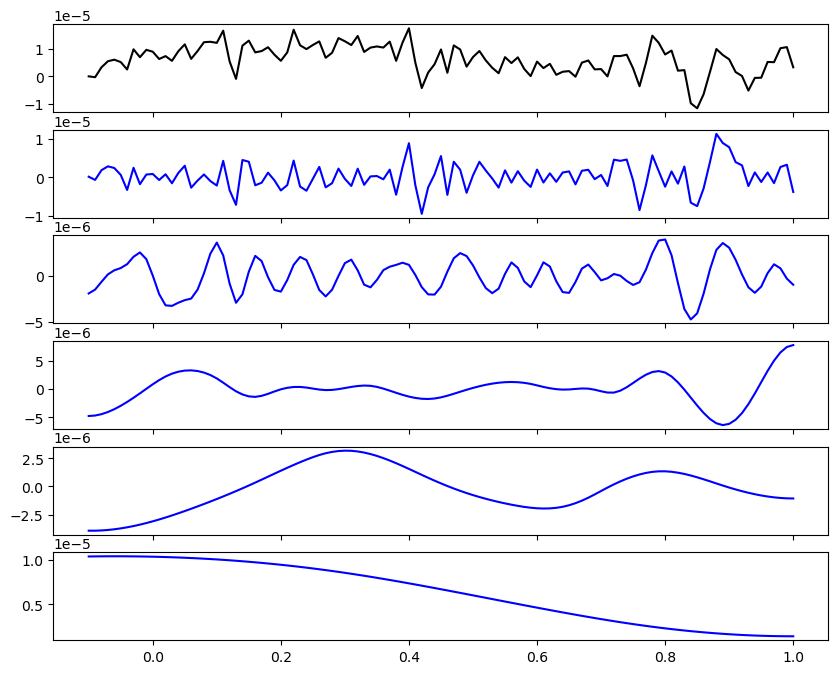

Loading Epochs for S027...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S027_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


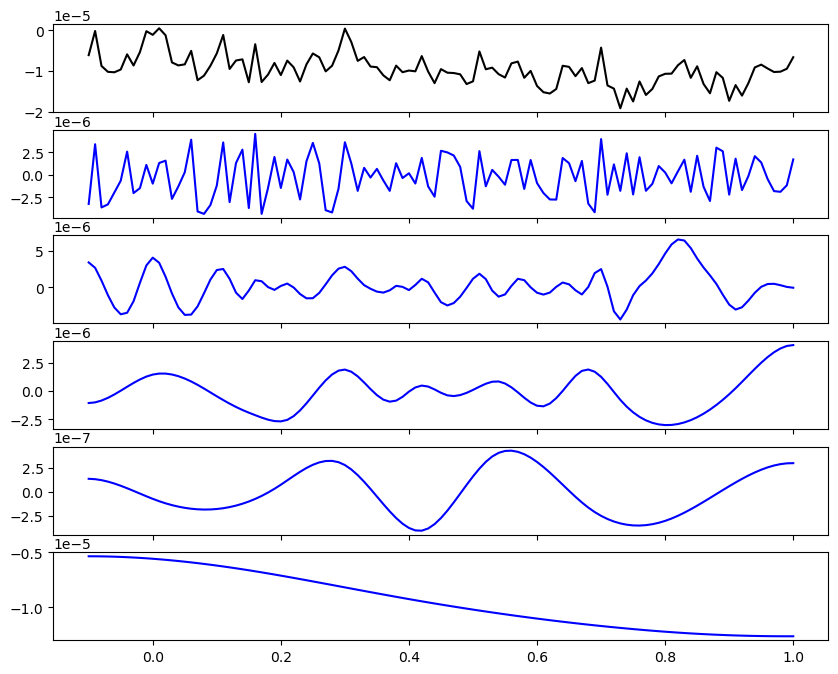

Loading Epochs for S023...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S023_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


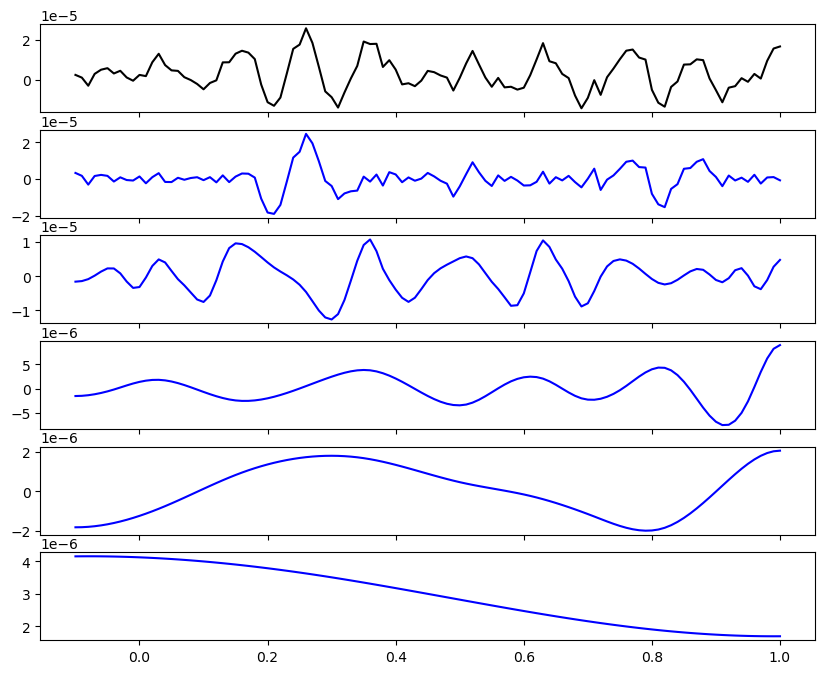

Loading Epochs for S034...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S034_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


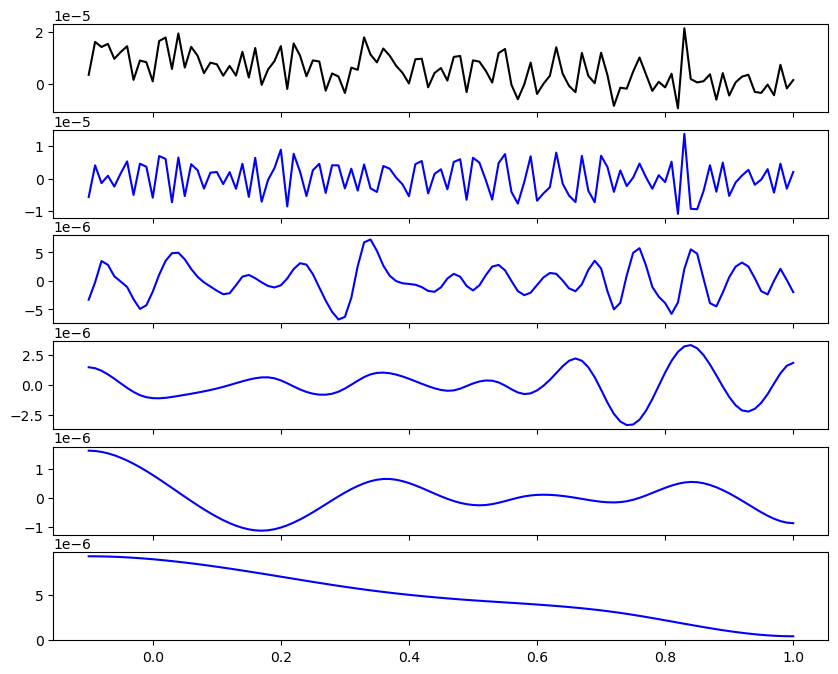

Loading Epochs for S024...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S024_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


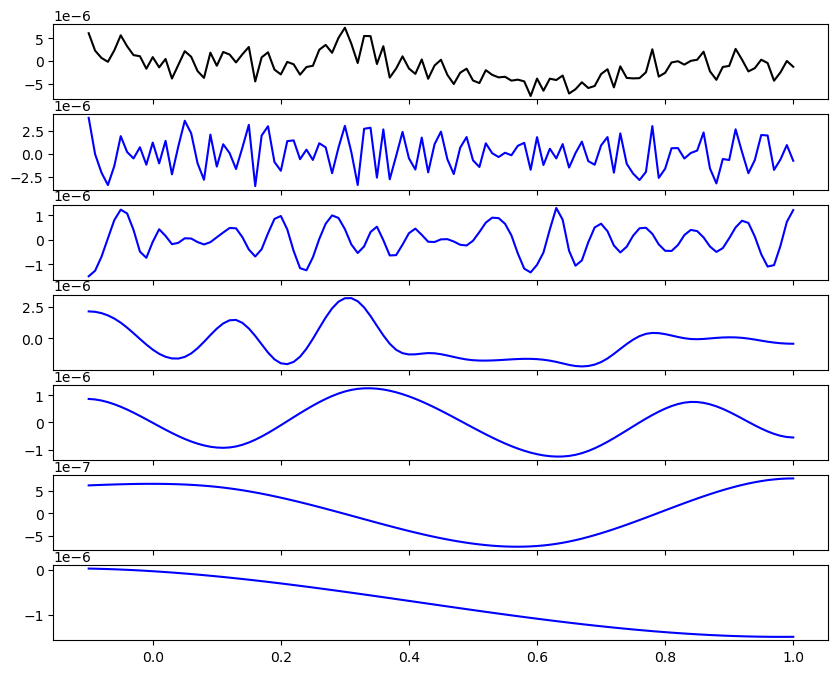

Loading Epochs for S019...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S019_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


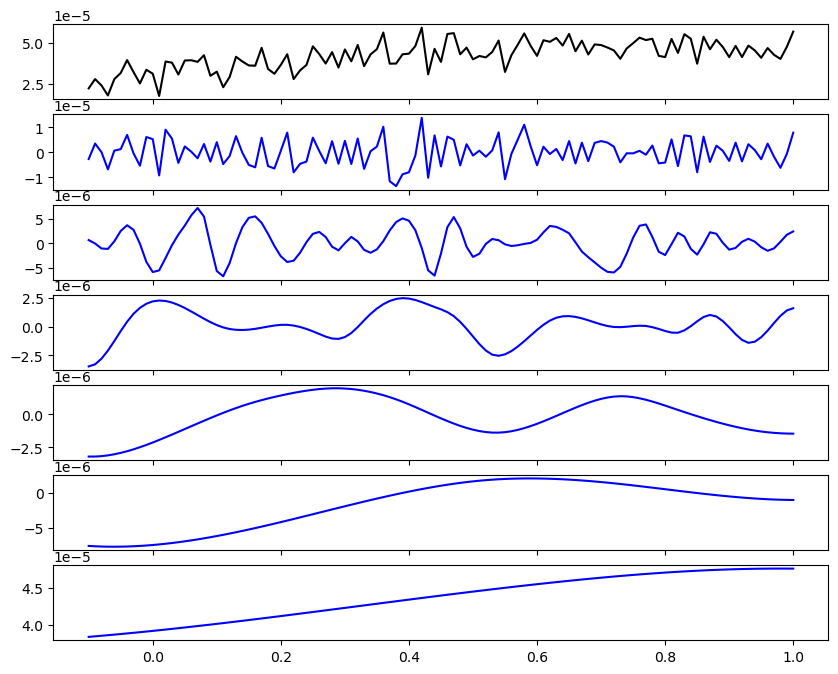

Loading Epochs for S020...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S020_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


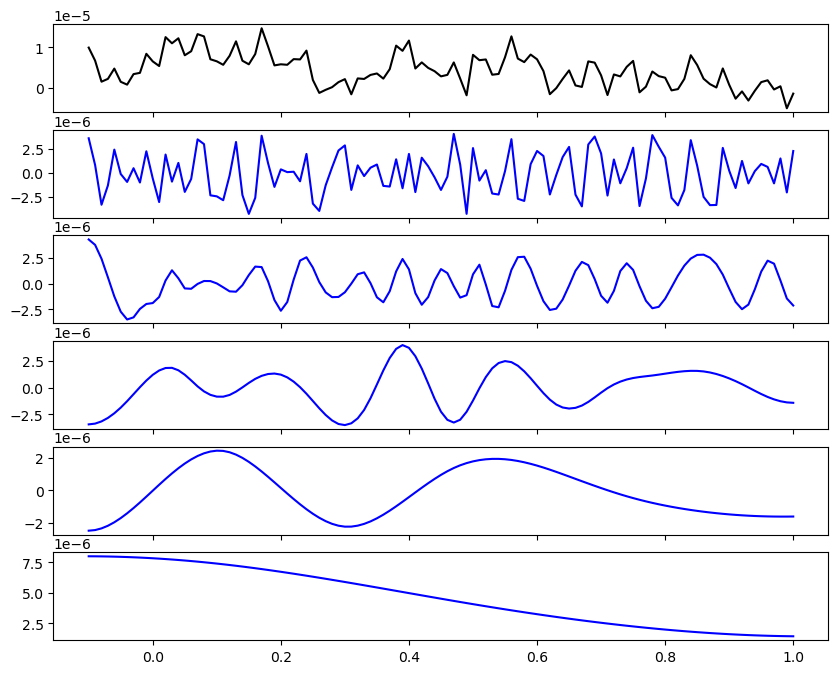

Loading Epochs for S013...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S013_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


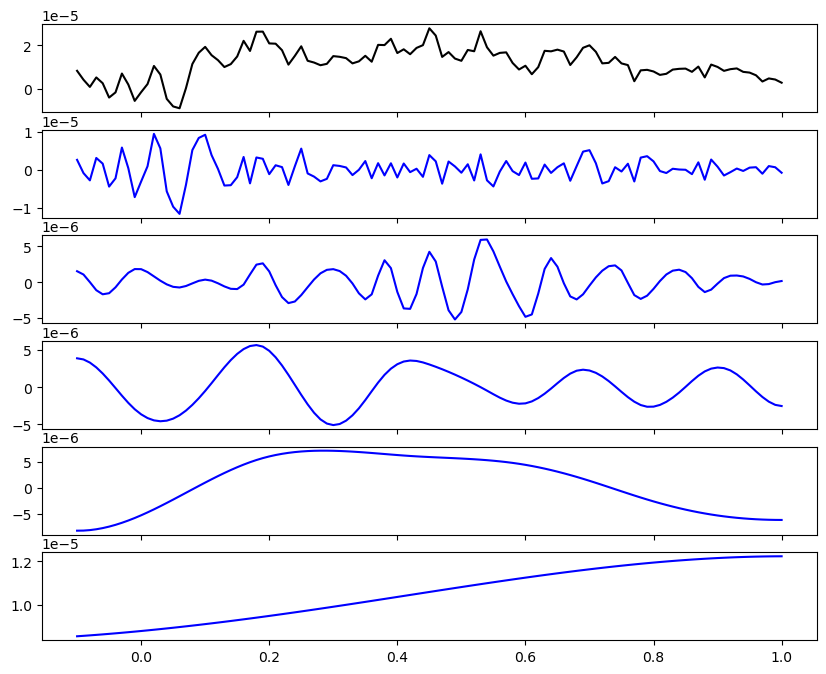

Loading Epochs for S017...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S017_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


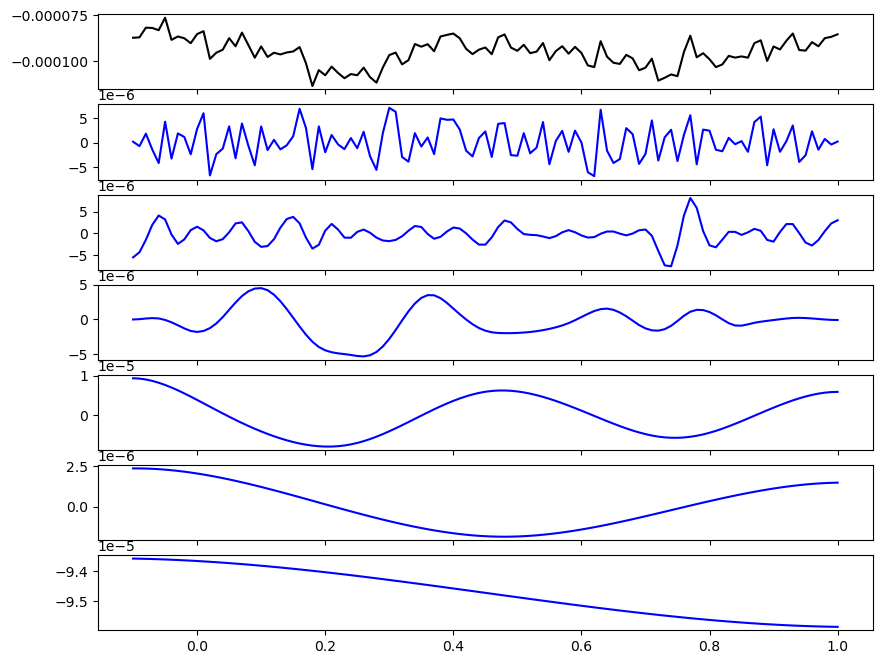

Loading Epochs for S039...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S039_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


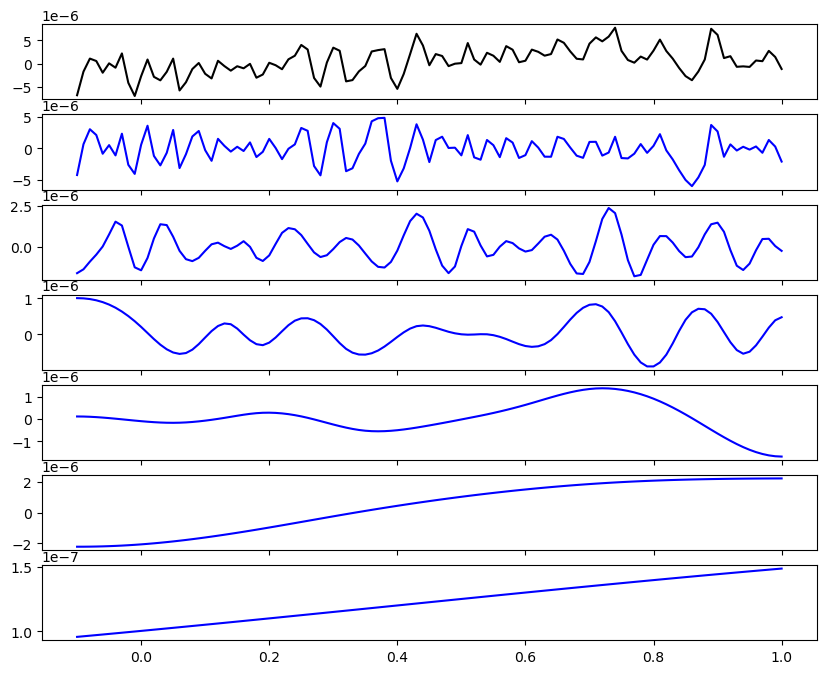

Loading Epochs for S010...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S010_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


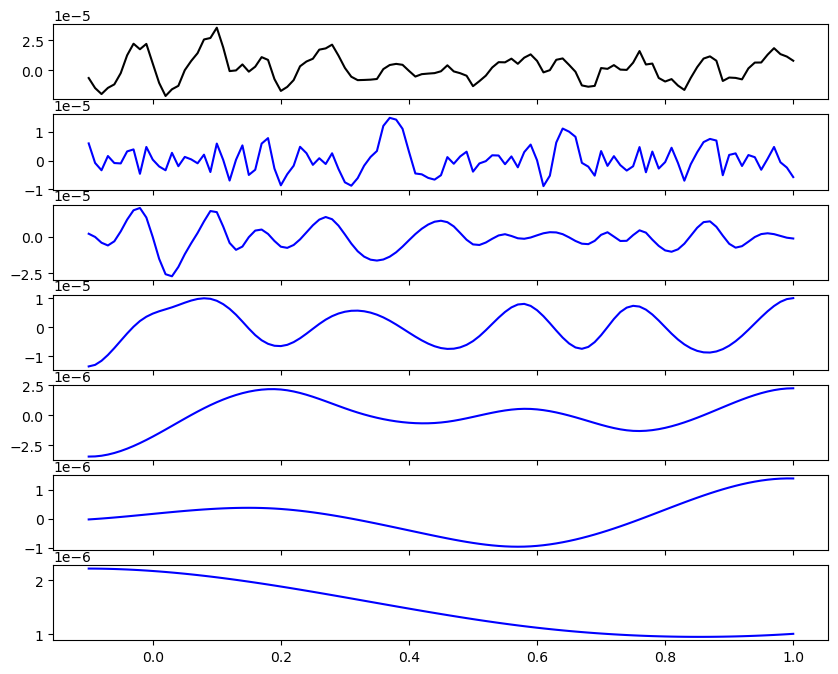

Loading Epochs for S029...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S029_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


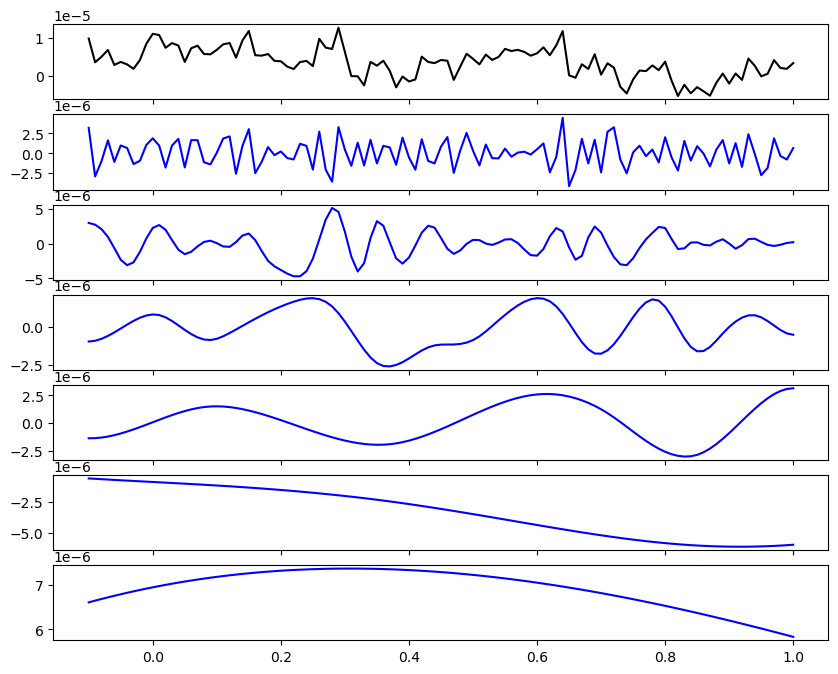

Loading Epochs for S015...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S015_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


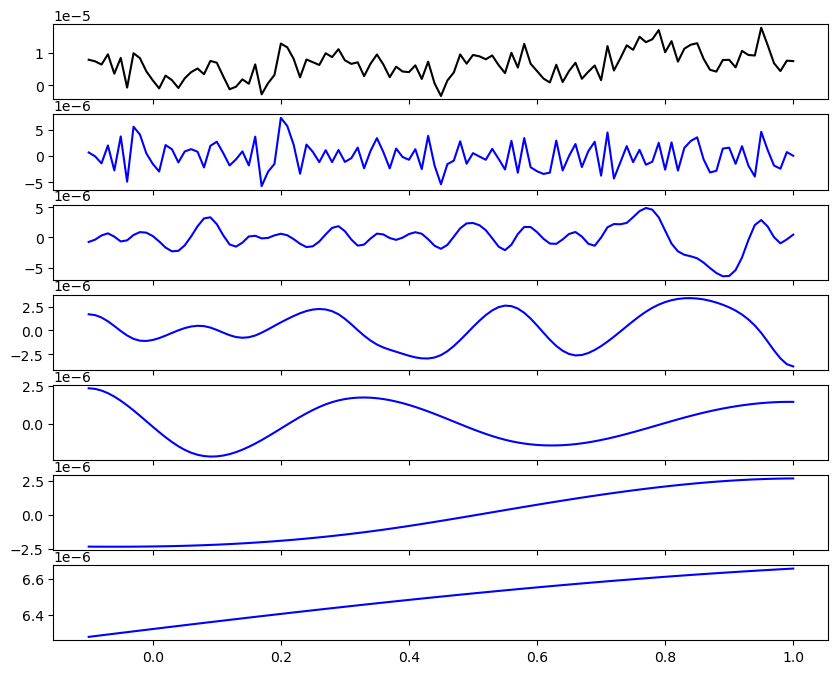

Loading Epochs for S028...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S028_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


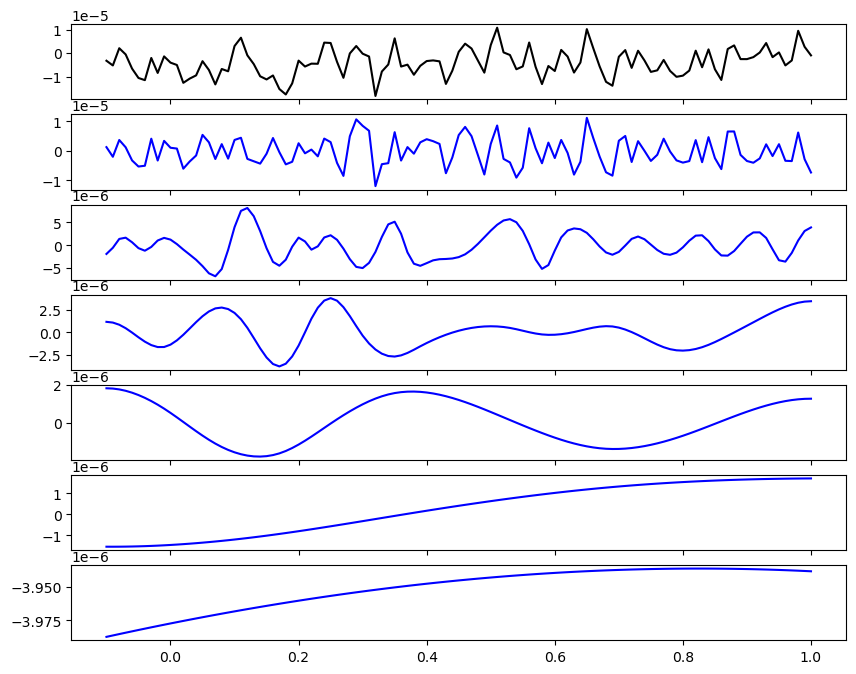

Loading Epochs for S011...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S011_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


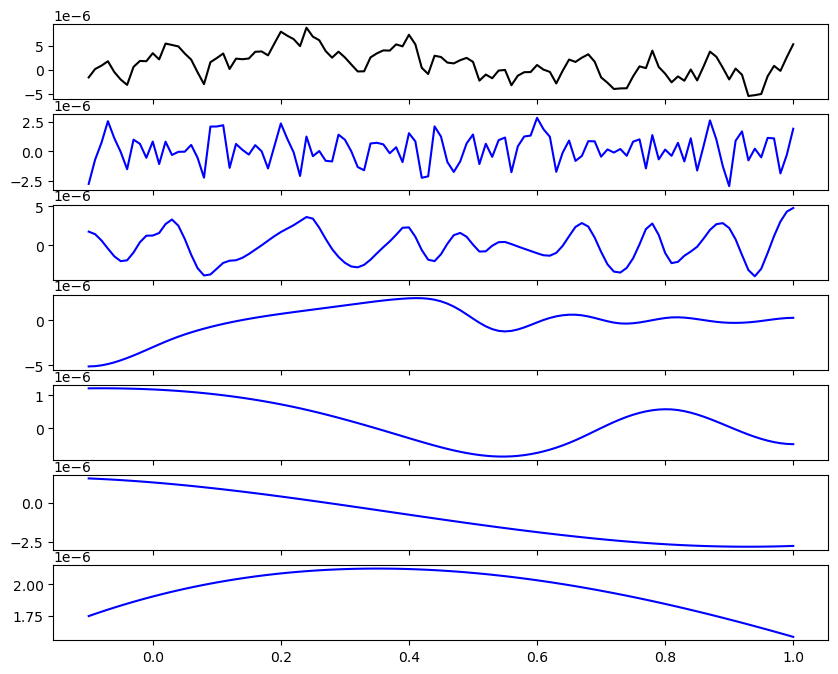

Loading Epochs for S038...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S038_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


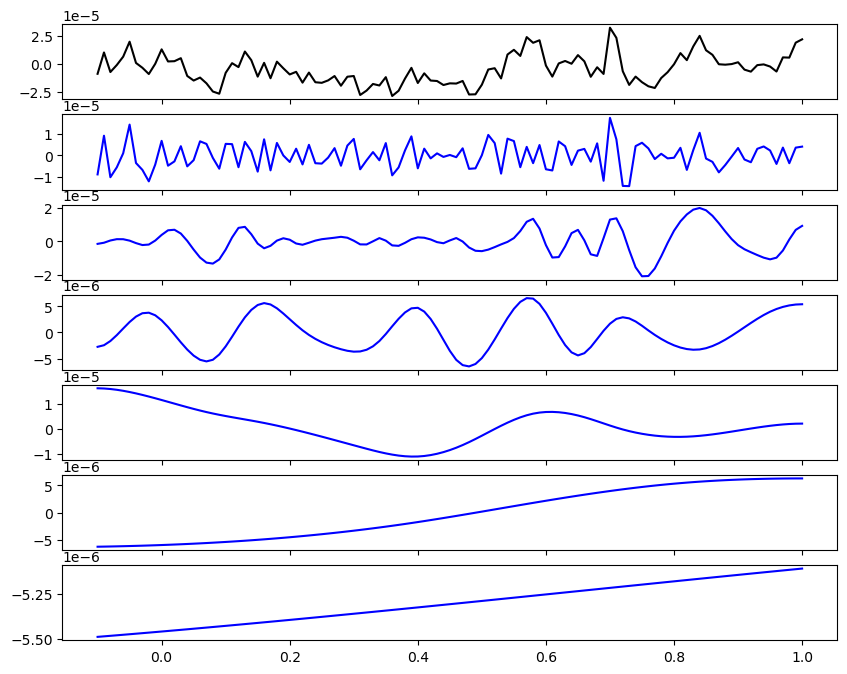

Loading Epochs for S016...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S016_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


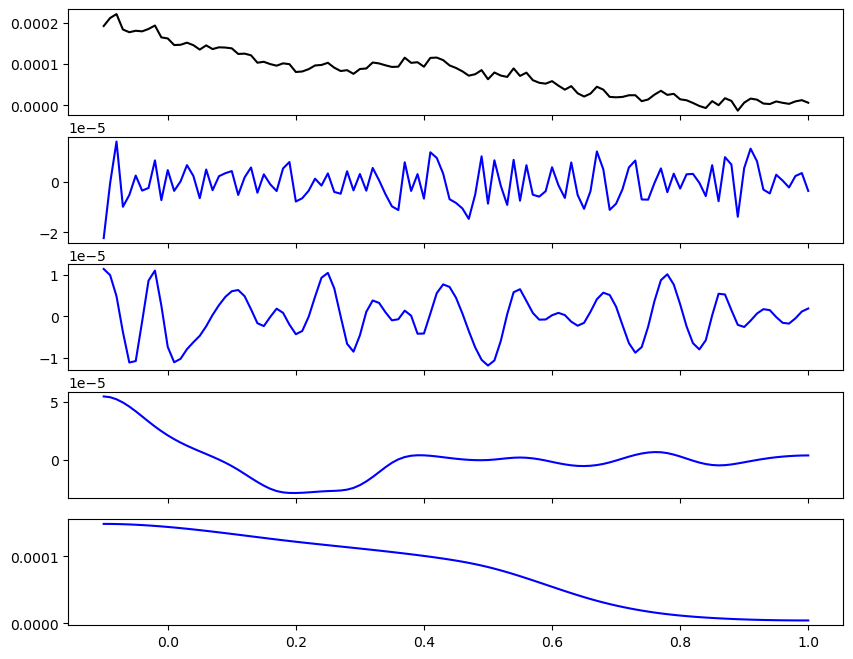

Loading Epochs for S012...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S012_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


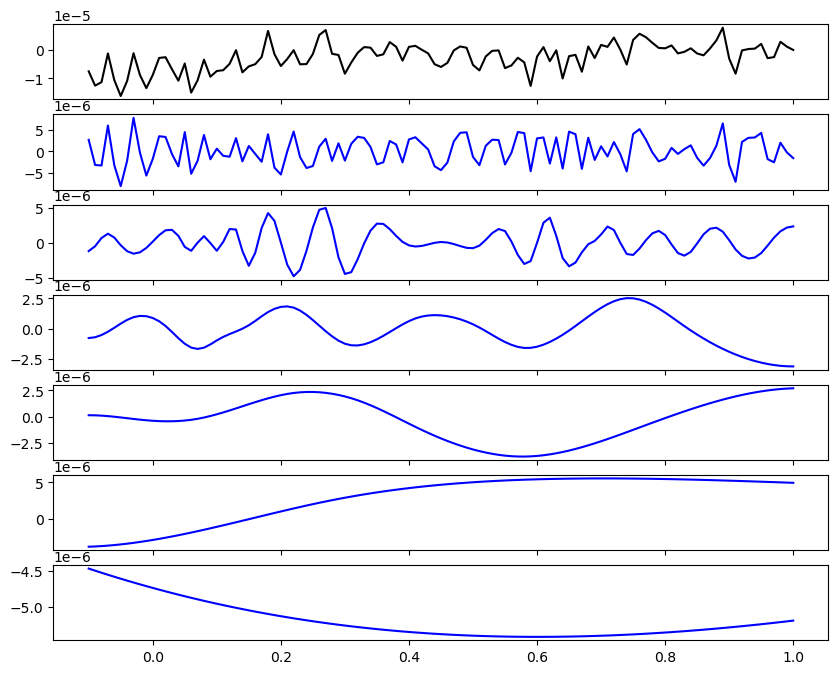

Loading Epochs for S021...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S021_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


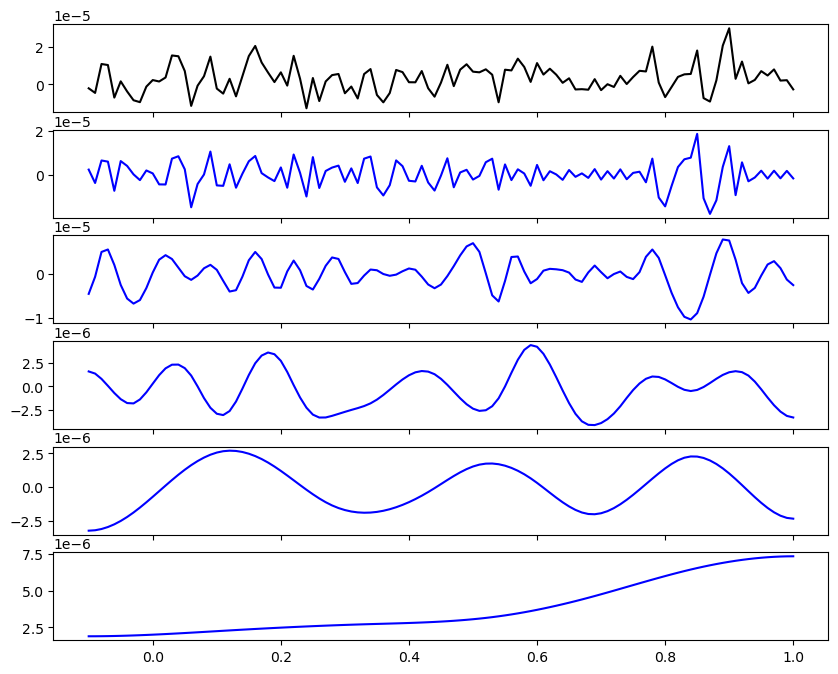

Loading Epochs for S036...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S036_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


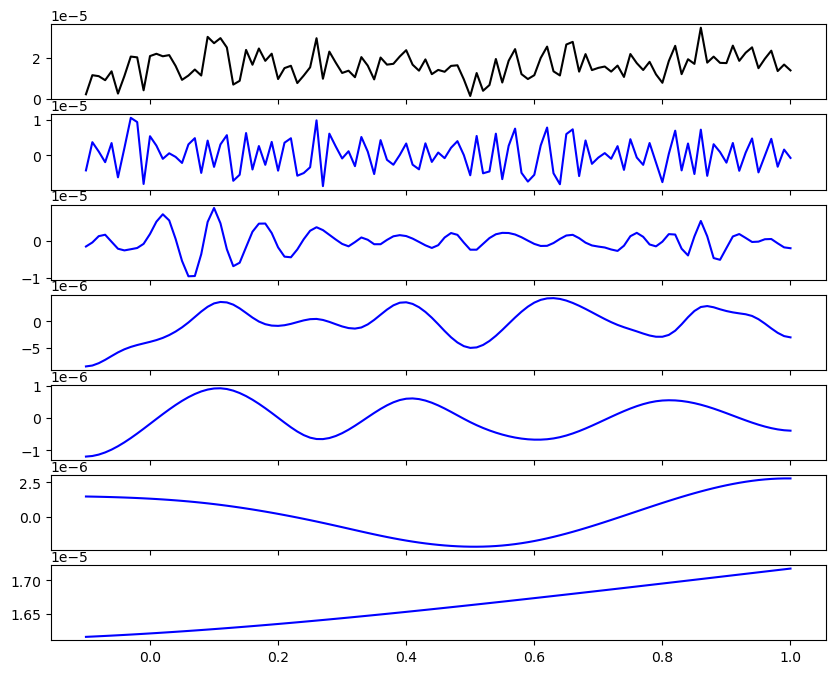

Loading Epochs for S032...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S032_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


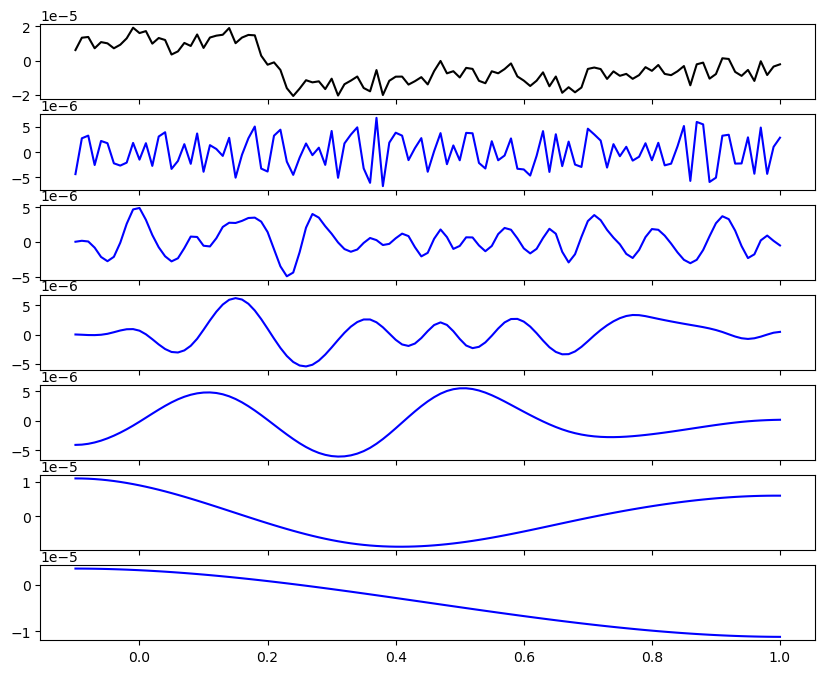

Loading Epochs for S025...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S025_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


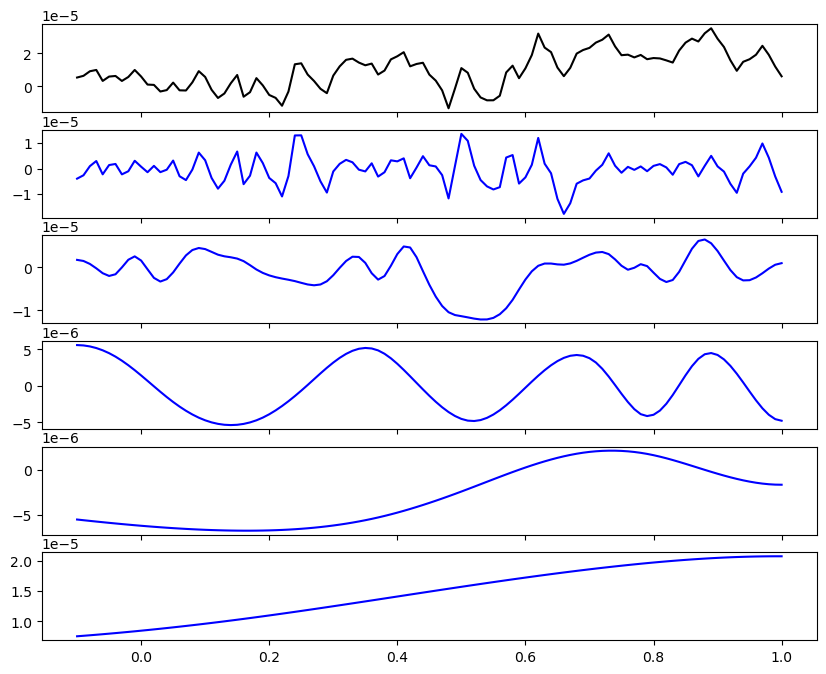

Loading Epochs for S035...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S035_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


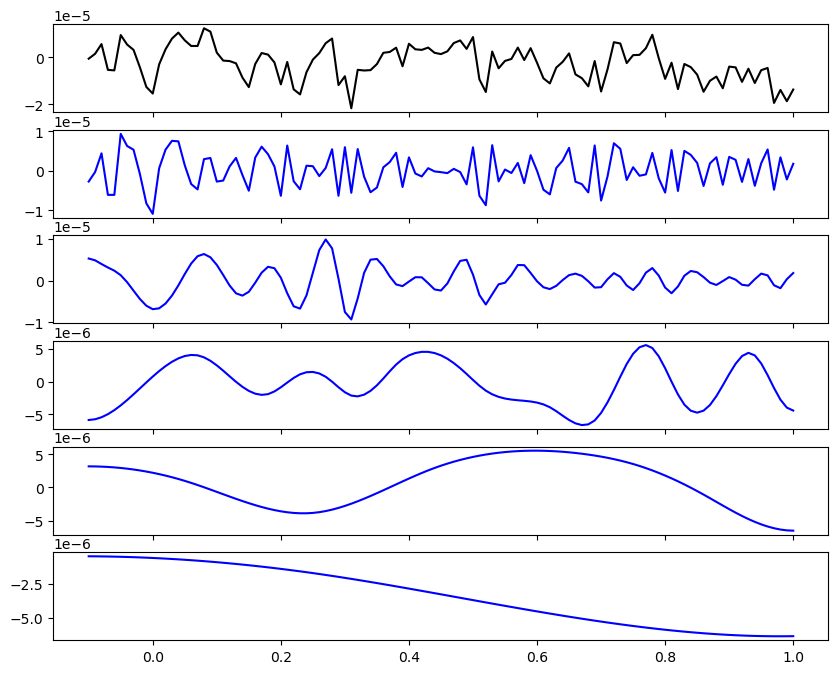

Loading Epochs for S022...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S022_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


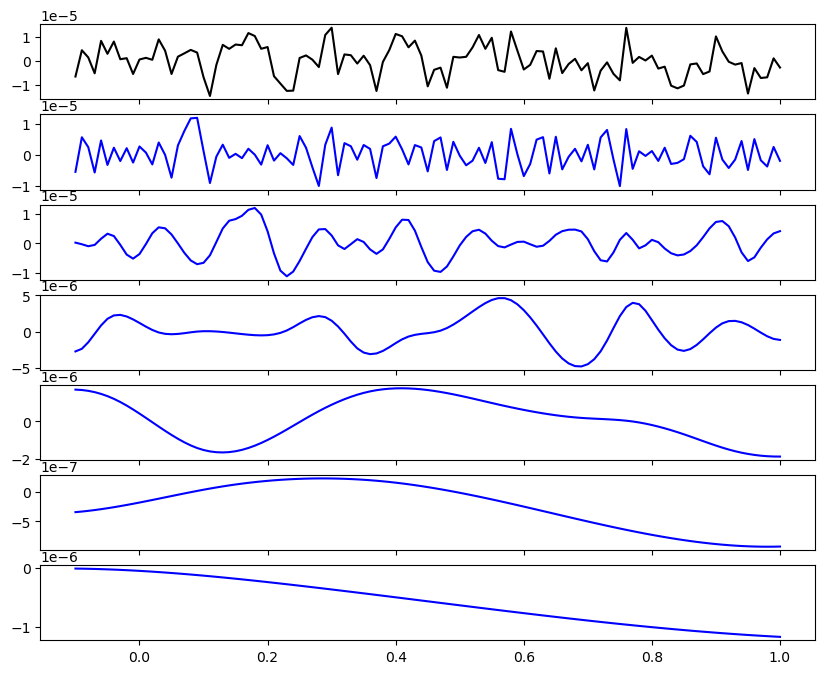

Loading Epochs for S026...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S026_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


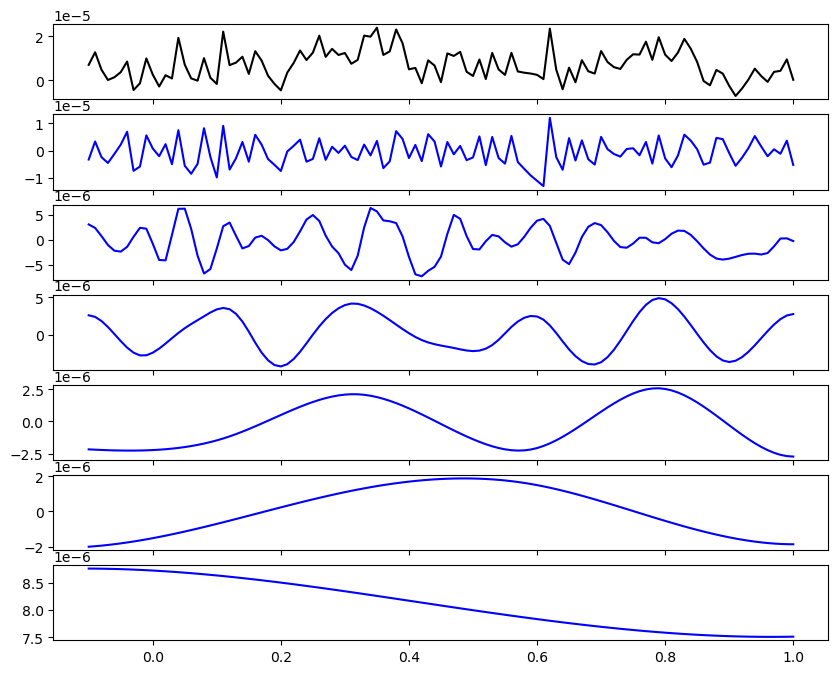

Loading Epochs for S031...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:38: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S031_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/4273316171.py:49: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Data Loaded Successfully: 111 samples
Running Layer 1 Sift...
Running Layer 2 Sift...


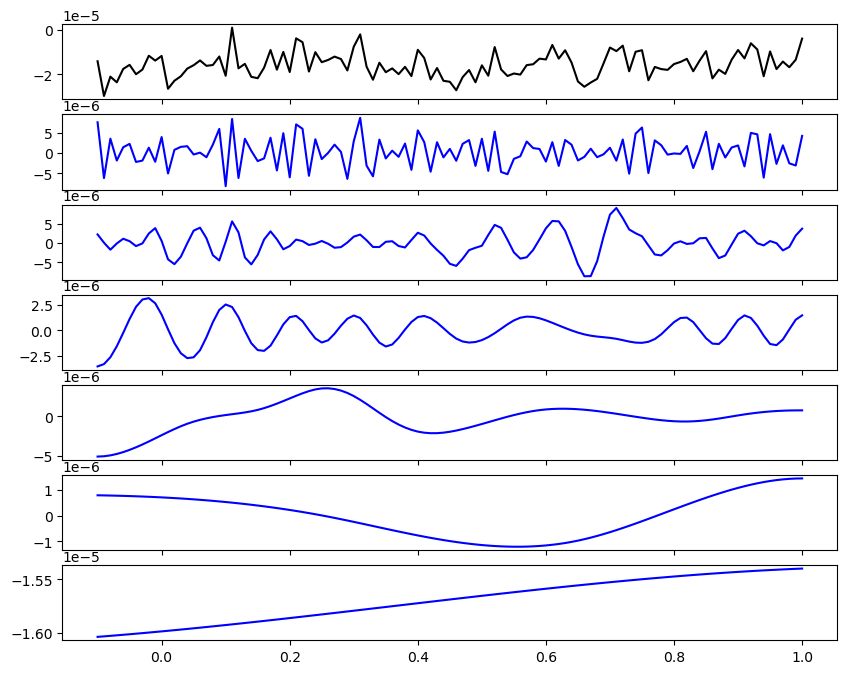

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from pathlib import Path
import emd
from scipy.signal import hilbert
import gc # Garbage Collector

# THIS WORKS!!!!
# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
#EPOCH_DIR = DATA_ROOT / 'wOnset_epochs' 
#TARGET_SUBJECT = 'S011' 

for subject in ESL_SUBJECTS: #[0:3]:
    TARGET_SUBJECT = subject[4:8]
    # Selection parameters
    TRIAL_INDEX = 1012 # This means it is the first word in the paragraphs
    CHANNEL_NAME = 'F3' # Change this to your actual channel name (e.g., 'Cz')
    TARGET_IMF_INDEX = 0 
    
    # ==========================================
    # 2. LOAD DATA (MNE Epochs)
    # ==========================================
    # Fixed filename to match your exact saved file from the warning
    file_name = f'{TARGET_SUBJECT}_ESLs_wOnset_epochs_allTapes_raw.fif'
    file_path = wOnset_DIR / file_name
    
    print(f"Loading Epochs for {TARGET_SUBJECT}...")
    
    # Initialize signal as None to prevent NameError later
    signal = None
    
    try:
        # Use verbose=False to quiet the naming convention warning
        epochs = mne.read_epochs(file_path, preload=True, verbose=False)
        
        # 1. Pick Channel (Check if channel exists first)
        if CHANNEL_NAME not in epochs.ch_names:
            print(f"Warning: {CHANNEL_NAME} not found. Using first available channel: {epochs.ch_names[0]}")
            CHANNEL_NAME = epochs.ch_names[0]
        
        epochs.pick_channels([CHANNEL_NAME])
        
        # 2. Extract Data 
        # MNE shape: (trials, channels, times)
        data = epochs.get_data() 
        
        # Ensure it's a 1D array for EMD
        signal = data[TRIAL_INDEX, 0, :].flatten()
        
        times = epochs.times
        fs = epochs.info['sfreq']
        
        # Clean up epoch object to save RAM
        del epochs
        gc.collect()
    
        print(f"Data Loaded Successfully: {len(signal)} samples")
    
    except Exception as e:
        print(f"FATAL ERROR during loading: {e}")
        # Stop execution if data didn't load
        raise 
    
    # ==========================================
    # 3. PROCESSING (Only runs if signal exists)
    # ==========================================
    
    if signal is not None:
        # --- A. Layer 1 Decomposition ---
        # Mirror Padding to prevent edge effects
        pad_width = len(signal)
        padded_signal = np.pad(signal, pad_width, mode='reflect')
    
        print("Running Layer 1 Sift...")
        # Using sift (standard) or ensemble_sift (CEEMDAN-like)
        # nprocesses helps speed but can crash some kernels; set to 1 if it crashes
        imfs_layer1_padded = emd.sift.sift(padded_signal, max_imfs=5)
    
        # Un-pad
        imfs_layer1 = imfs_layer1_padded[pad_width : pad_width + len(signal), :]
        n_imfs1 = imfs_layer1.shape[1]
    
        # --- B. Layer 2 Decomposition ---
        target_imf_padded = imfs_layer1_padded[:, TARGET_IMF_INDEX]
    
        # Analytic signal for envelope
        analytic = hilbert(target_imf_padded)
        envelope_padded = np.abs(analytic)
    
        print("Running Layer 2 Sift...")
        imfs_layer2_padded = emd.sift.sift(envelope_padded, max_imfs=4)
    
        # Un-pad
        envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
        imfs_layer2 = imfs_layer2_padded[pad_width : pad_width + len(signal), :]
        n_imfs2 = imfs_layer2.shape[1]
    
        # ==========================================
        # 4. PLOTTING
        # ==========================================
        # (Plotting code remains the same as previous)
        
        fig1, axes1 = plt.subplots(n_imfs1 + 1, 1, figsize=(10, 8), sharex=True)
        axes1[0].plot(times, signal, 'k')
        for i in range(n_imfs1):
            axes1[i+1].plot(times, imfs_layer1[:, i], 'b')
        plt.savefig(wOnset_DIR / Path('ESLs_%s_%s_word%s_layer1-IMFs_wOnset.png' %(TARGET_SUBJECT, CHANNEL_NAME, TRIAL_INDEX)))
        plt.show()
                    
    else:
        print("Processing skipped because signal was not defined.")

In [111]:
import mne
import scipy.io
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
EPOCH_DIR = wOnset_DIR # DATA_ROOT / 'wOnset_epochs'
MAT_OUTPUT_DIR = wOnset_DIR / 'ESLs_MAT_Files_for_HHSA'
MAT_OUTPUT_DIR.mkdir(exist_ok=True)

CHANNEL_TO_EXPORT = 'F3'  # The channel used in your figures

# Get list of all epoch files
epoch_files = list(EPOCH_DIR.glob('*_wOnset_epochs_allTapes_raw.fif'))

for f_path in epoch_files:
    subject_id = f_path.name.split('_')[0]
    print(f"Exporting {subject_id}...")
    
    try:
        # 1. Load Epochs
        epochs = mne.read_epochs(f_path, preload=True, verbose=False)
        
        # 2. Pick Channel
        if CHANNEL_TO_EXPORT in epochs.ch_names:
            epochs.pick_channels([CHANNEL_NAME])
        else:
            print(f"  Warning: {CHANNEL_TO_EXPORT} not found in {subject_id}. Skipping.")
            continue
            
        # 3. Extract Data: MNE is (Trials, Channels, Time)
        # We need (Time, Trials) for your MATLAB script
        data = epochs.get_data() # Shape: (n_trials, 1, n_times)
        mat_data = np.squeeze(data).T # Shape: (n_times, n_trials)
        
        # 4. Save to .mat
        save_dict = {
            'D_a': mat_data,
            'fs': epochs.info['sfreq'],
            'times': epochs.times,
            'subject_id': subject_id
        }
        
        scipy.io.savemat(MAT_OUTPUT_DIR / f"{subject_id}_ESLs_HHSA_input.mat", save_dict)
        
    except Exception as e:
        print(f"  Failed to export {subject_id}: {e}")

print(f"Export complete. Files saved to: {MAT_OUTPUT_DIR}")

Exporting S030...
Exporting S023...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S030_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S023_ESLs_wOnset_epochs_allTapes_raw.fif) does 

Exporting S020...
Exporting S017...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S036_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S036...
Exporting S012...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S025_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S025...
Exporting S039...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S035_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S035...
Exporting S011...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S026_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S026...
Exporting S029...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S015_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S015...
Exporting S022...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S031_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S031...
Exporting S016...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S021_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S021...
Exporting S032...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S019_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S019...
Exporting S024...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S013_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S013...
Exporting S038...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S027_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S027...
Exporting S010...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:23: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S034_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1,

Exporting S034...
Exporting S028...
Export complete. Files saved to: /Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/ESLs_MAT_Files_for_HHSA


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1821164056.py:34: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data() # Shape: (n_trials, 1, n_times)


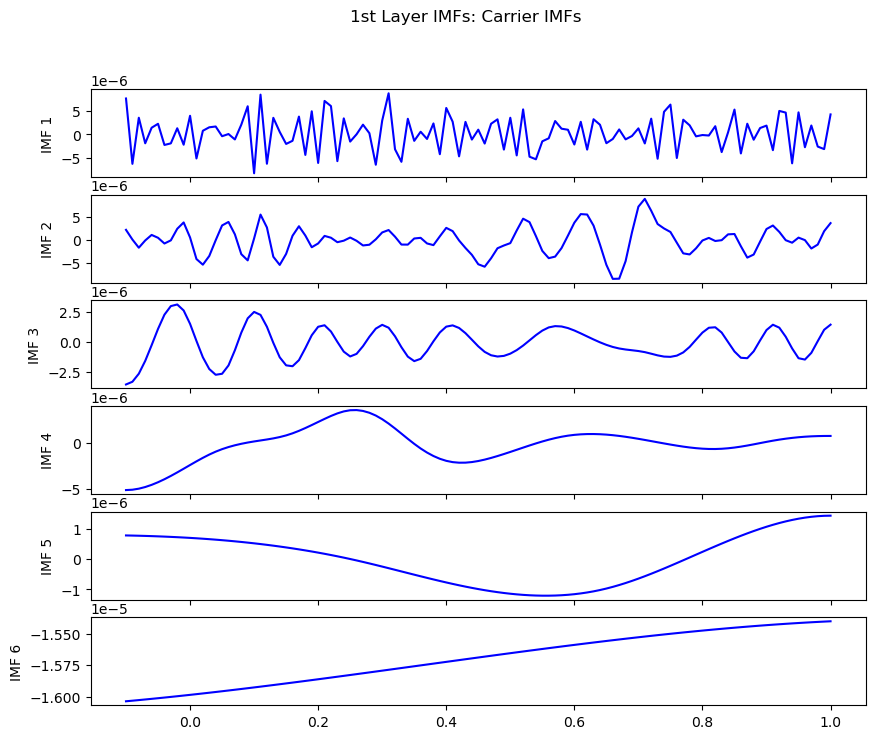

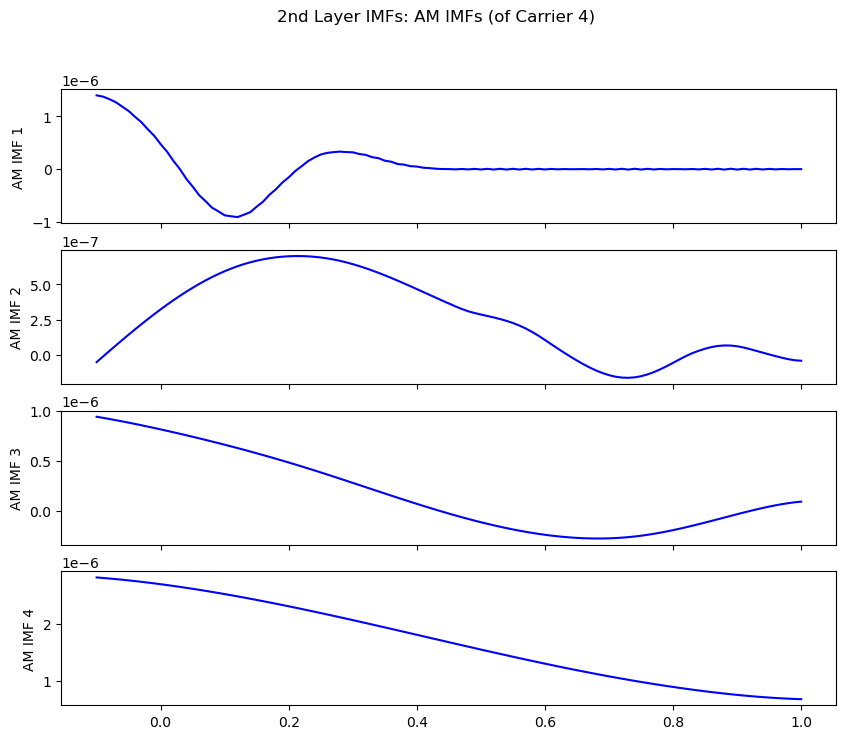

In [126]:
# import numpy as np
# import mne
# import emd
# from scipy.signal import hilbert
# import matplotlib.pyplot as plt

## This works!! For showing 1st & 2nd IMFs

# --- 1. Signal Preparation ---
# signal shape should be (151,)
# fs is your sampling rate (e.g., 100)

# Mirror Padding to prevent edge artifacts on short 151-sample epochs
pad_width = len(signal) 
padded_signal = np.pad(signal, pad_width, mode='reflect')

# --- 2. Layer 1: Carrier Decomposition ---
# This breaks the brain signal into frequency bands (e.g., Theta, Delta)
imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=7)

# Un-pad to get the real data back
imfs_layer1 = imfs_l1_padded[pad_width : pad_width + len(signal), :]

# --- 3. Layer 2: AM Decomposition ---
# Choose which Carrier IMF to look 'inside' of (e.g., Index 1 for Delta/Word level)
TARGET_IMF_IDX = 3 
target_imf_padded = imfs_l1_padded[:, TARGET_IMF_IDX]

# Extract the Amplitude Envelope using Hilbert Transform
envelope_padded = np.abs(hilbert(target_imf_padded))

# Sift the Envelope again (Second EMD)
imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=6)

# Un-pad Layer 2 results
imfs_layer2 = imfs_l2_padded[pad_width : pad_width + len(signal), :]
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]

# --- 4. Visualization ---
def plot_layers(data, times, title, ylabel_prefix):
    n_imfs = data.shape[1]
    fig, axes = plt.subplots(n_imfs, 1, figsize=(10, 8), sharex=True)
    for i in range(n_imfs):
        axes[i].plot(times, data[:, i], color='blue')
        axes[i].set_ylabel(f"{ylabel_prefix} {i+1}")
    plt.suptitle(title)
    plt.savefig(wOnset_DIR / Path('ESLs_%s_%s_word%s_2LayerIMFs_IMF%s_wOnset.png' %(TARGET_SUBJECT, CHANNEL_NAME, TRIAL_INDEX, TARGET_IMF_IDX+1)))
    plt.show()

# Plot Layer 1 (Carriers)
plot_layers(imfs_layer1, times, "1st Layer IMFs: Carrier IMFs", "IMF")

# Plot Layer 2 (Modulations of the selected Carrier)
plot_layers(imfs_layer2, times, f"2nd Layer IMFs: AM IMFs (of Carrier {TARGET_IMF_IDX+1})", "AM IMF")

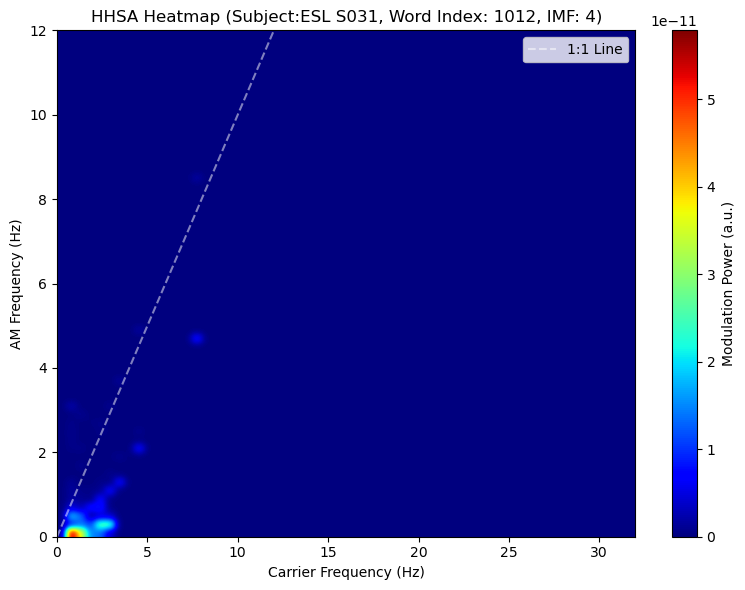

In [131]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import hilbert

# This works !! for HHSA Heatmap

# --- 1. SETTINGS ---
NBINS = 60
LIMIT_CARRIER = 32 # 12 # X-axis limit (Hz)
LIMIT_AM = 12 # 6       # Y-axis limit (Hz)
TRIAL_INDEX = 1012 # This means it is the first word in the paragraphs
TARGET_IMF_IDX = 3
#CHANNEL_NAME = 'FP1' # Change this to your actual channel name (e.g., 'Cz')

# --- 2. CALCULATE INSTANTANEOUS FREQUENCY ---
def get_inst_info(sig, sr):
    analytic = hilbert(sig)
    phase = np.unwrap(np.angle(analytic))
    # Frequency is the derivative of the phase
    freq = np.append(np.diff(phase) / (2.0 * np.pi) * sr, 0)
    return freq

# Extract Carrier Frequency (from the Layer 1 IMF you selected)
# Use the un-padded imfs_layer1 from your previous code
freq_carrier = get_inst_info(imfs_layer1[:, TARGET_IMF_IDX], fs)

# --- 3. ACCUMULATE HOLO-DATA POINTS ---
holo_points = []

# Loop through all AM IMFs from Layer 2
for j in range(imfs_layer2.shape[1]):
    # Get AM Frequency for this component
    freq_am = get_inst_info(imfs_layer2[:, j], fs)
    
    # Calculate Power (Energy) of this AM component
    power_am = imfs_layer2[:, j]**2
    
    # Filter for valid ranges (Positive frequencies below limits)
    mask = (freq_carrier > 0) & (freq_carrier < LIMIT_CARRIER) & \
           (freq_am > 0) & (freq_am < LIMIT_AM)
    
    if np.any(mask):
        # Stack: [Carrier_Freq, AM_Freq, Power]
        pts = np.vstack((freq_carrier[mask], freq_am[mask], power_am[mask])).T
        holo_points.append(pts)

# Combine all points into one matrix
holo_data = np.vstack(holo_points)

# --- 4. CREATE THE HEATMAP ---
# Weighted 2D histogram
H, x_edges, y_edges = np.histogram2d(
    holo_data[:, 0], holo_data[:, 1], 
    bins=NBINS, 
    weights=holo_data[:, 2], 
    range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]]
)

# --- 5. PLOT ---
plt.figure(figsize=(8, 6))
# We use .T because imshow expects [y, x] but histogram2d returns [x, y]
plt.imshow(H.T, origin='lower', cmap='jet', aspect='auto', interpolation='gaussian',
           extent=[0, LIMIT_CARRIER, 0, LIMIT_AM])

plt.colorbar(label='Modulation Power (a.u.)')
plt.xlabel('Carrier Frequency (Hz)')
plt.ylabel('AM Frequency (Hz)')
plt.title(f'HHSA Heatmap (Subject:ESL {TARGET_SUBJECT}, Word Index: {TRIAL_INDEX}, IMF: {TARGET_IMF_IDX+1})')

# Add the 1:1 diagonal line (AM frequency cannot exceed Carrier frequency)
plt.plot([0, LIMIT_AM], [0, LIMIT_AM], 'w--', alpha=0.5, label='1:1 Line')
plt.legend()
plt.tight_layout()
plt.savefig(wOnset_DIR / Path('ESLs_%s_%s_HHSA_%s_word%s_wOnset.png' %(TARGET_SUBJECT, CHANNEL_NAME, TARGET_IMF_IDX, TRIAL_INDEX)))
plt.show()

In [47]:
# import numpy as np
# import mne
# import emd
# from scipy.signal import hilbert
# import gc
# from pathlib import Path

# This Works !! For group Average of tape 1

# --- A. DEFINE THE ANALYSIS PIPELINE ---
def run_hhsa_pipeline(signal, fs):
    """Performs Two-Layer EMD with Padding and IF calculation."""
    # 1. Padding
    pad_width = len(signal)
    padded_signal = np.pad(signal, pad_width, mode='reflect')

    # 2. Layer 1 Sift (Carrier)
    try:
        imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5).T
        # We target IMF 2 (Index 1) as the carrier
        target_imf_padded = imfs_l1_padded[1]
    except:
        return None

    # 3. Layer 2 Sift (AM)
    analytic_c = hilbert(target_imf_padded)
    envelope_padded = np.abs(analytic_c)
    
    try:
        imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4).T
    except:
        return None

    # 4. Extract Real parts and Calculate Frequencies
    # Carrier IF
    imf_c_real = target_imf_padded[pad_width : pad_width + len(signal)]
    phase_c = np.unwrap(np.angle(hilbert(imf_c_real)))
    freq_c = np.append(np.diff(phase_c) / (2.0 * np.pi) * fs, 0)

    all_points = []
    for j in range(imfs_l2_padded.shape[0]):
        # AM IF
        imf_am_real = imfs_l2_padded[j, pad_width : pad_width + len(signal)]
        phase_am = np.unwrap(np.angle(hilbert(imf_am_real)))
        freq_am = np.append(np.diff(phase_am) / (2.0 * np.pi) * fs, 0)
        power_am = imf_am_real**2
        
        # Combine [fc, fam, power]
        pts = np.vstack((freq_c, freq_am, power_am)).T
        all_points.append(pts)

    return np.vstack(all_points)

# --- B. PROCESS ALL SUBJECTS ---
GROUP_NAME = "ESLs" # Change to "ESLs" in your second notebook
NBINS = 60
LIMIT_CARRIER, LIMIT_AM = 30, 15
subject_heatmaps = []

for subject in ESL_SUBJECTS:
    print(f"Subject: {subject[4:8]}")
    file_path = wOnset_DIR / f'{subject[4:8]}_ESLs_wOnset_epochs_allTapes_raw.fif'
    
    try:
        epochs = mne.read_epochs(file_path, preload=True, verbose=False)
        # Select Tape 1 (first 171 words)
        tape1_data = epochs[0:171].get_data() 
        # Average across trials to get the evoked signal (151 samples)
        avg_signal = tape1_data.mean(axis=0)[0, :]
        fs = epochs.info['sfreq']

        holo_data = run_hhsa_pipeline(avg_signal, fs)
        
        if holo_data is not None:
            H, _, _ = np.histogram2d(holo_data[:, 0], holo_data[:, 1], bins=NBINS, 
                                     weights=holo_data[:, 2], 
                                     range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
            subject_heatmaps.append(H)
        
        del epochs, tape1_data
        gc.collect()
    except Exception as e:
        print(f"  Error on {subject}: {e}")

# Save the final matrix
np.save(wOnset_DIR /f"{GROUP_NAME}_tape1_heatmaps.npy", np.array(subject_heatmaps))

Subject: S030


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S030_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S027_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to M

Subject: S027


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S023_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S023


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S034_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S034


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S024_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S024


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S019


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S019_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S020_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to M

Subject: S020


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S013_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S013


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S017


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S017_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S039_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to M

Subject: S039


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S010_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S010


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S029_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S029


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S015_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S015


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S028_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S028


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S011_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S011


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S038_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S038


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S016_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S016


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S012_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S012


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S021_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S021


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S036_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S036


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S032_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S032


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S025


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S025_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S035_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to M

Subject: S035


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


Subject: S022


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S022_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S026_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to M

Subject: S026


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:65: RuntimeWarning: This filename (/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results/EEG_ESLs/Alice_ESLs_wOnset_raw_epochs/S031_ESLs_wOnset_epochs_allTapes_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Subject: S031


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_40773/1877031702.py:67: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  tape1_data = epochs[0:171].get_data()


import numpy as np
import matplotlib.pyplot as plt
from mne.stats import spatio_temporal_cluster_test

## For permutation test of both groups

# 1. Load saved data
natives = np.load(wOnset_DIR / "Natives_tape1_heatmaps.npy") # (33, 60, 60)
esls = np.load(wOnset_DIR / "ESLs_tape1_heatmaps.npy")       # (26, 60, 60)

# 2. Format for MNE: [group1_array, group2_array]
X = [natives, esls]

# 3. Run Permutation Test
# threshold: T-value where clusters start forming (2.0 is roughly p < 0.05)
t_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_test(
    X, 
    threshold=2.0, 
    n_permutations=1000, 
    tail=0, # Two-tailed
    n_jobs=-1
)

# 4. Plot Results
plt.figure(figsize=(10, 8))
# T-obs is (60, 60), we transpose for [Carrier, AM] plotting
plt.imshow(t_obs.T, origin='lower', extent=[0, 12, 0, 6], cmap='RdBu_r')
plt.colorbar(label='T-statistic')

# Overlay Significant Clusters (p < 0.05)
for i, p_val in enumerate(cluster_pv):
    if p_val < 0.05:
        # Create a boolean mask for the significant cluster
        mask = clusters[i].astype(float)
        plt.contour(mask.T, colors='black', levels=[0.5], extent=[0, 12, 0, 6])
        print(f"Significant Cluster found! p-value: {p_val:.4f}")

plt.xlabel('Carrier Frequency (Hz)')
plt.ylabel('AM Frequency (Hz)')
plt.title('Permutation Test: Natives vs ESLs (Tape 1)')
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import mne
import emd
from pathlib import Path
from scipy.signal import hilbert
import gc

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
# Using the directory where your epochs are saved
EPOCH_DIR = DATA_ROOT / 'wOnset_epochs' 
TARGET_SUBJECT = 'S011'
CHANNEL_NAME = 'FP1' 
TRIAL_INDEX = 0          

# --- SELECT CARRIER TO ANALYZE ---
# 0 = IMF 1 (Theta/Acoustic), 1 = IMF 2 (Delta/Word), 2 = IMF 3 (Phrasal)
TARGET_IMF_L1 = 1        

# Heatmap Settings
NBINS = 60
LIMIT_CARRIER = 12       
LIMIT_AM = 6             

# ==========================================
# 2. LOAD DATA
# ==========================================
file_name = f'{TARGET_SUBJECT}_ESLs_wOnset_epochs_allTapes_raw.fif'
file_path = EPOCH_DIR / file_name # Use your actual path variable here

try:
    epochs = mne.read_epochs(file_path, preload=True, verbose=False)
    epochs.pick_channels([CHANNEL_NAME])
    signal = epochs.get_data()[TRIAL_INDEX, 0, :].flatten()
    fs = epochs.info['sfreq']
    times = epochs.times
    del epochs
    gc.collect()
except Exception as e:
    print(f"Error: {e}")
    raise

# ==========================================
# 3. HHSA PROCESSING (Two-Layer EMD)
# ==========================================
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# Layer 1: Carrier
imfs_l1_padded = emd.sift.sift(padded_signal, max_imfs=5)
imfs_l1 = imfs_l1_padded[pad_width : pad_width + len(signal), :]

# Layer 2: Modulation (Decomposing the Envelope of selected IMF)
target_imf_padded = imfs_l1_padded[:, TARGET_IMF_L1]
envelope_padded = np.abs(hilbert(target_imf_padded))
imfs_l2_padded = emd.sift.sift(envelope_padded, max_imfs=4)

imfs_l2 = imfs_l2_padded[pad_width : pad_width + len(signal), :]
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]

# ==========================================
# 4. SPECTRAL HEATMAP CALCULATION
# ==========================================
def get_inst_info(sig, sr):
    analytic = hilbert(sig)
    phase = np.unwrap(np.angle(analytic))
    freq = np.append(np.diff(phase) / (2.0 * np.pi) * sr, 0)
    return freq

freq_carrier = get_inst_info(imfs_l1[:, TARGET_IMF_L1], fs)
all_points = []

for j in range(imfs_l2.shape[1]):
    freq_am = get_inst_info(imfs_l2[:, j], fs)
    power_am = imfs_l2[:, j]**2
    mask = (freq_carrier > 0) & (freq_carrier < LIMIT_CARRIER) & \
           (freq_am > 0) & (freq_am < LIMIT_AM)
    if np.any(mask):
        all_points.append(np.vstack((freq_carrier[mask], freq_am[mask], power_am[mask])).T)

holo_data = np.vstack(all_points)

# ==========================================
# 5. PLOTTING
# ==========================================
# Robust plotting helper to avoid math domain errors
def safe_plot(data, sr, title):
    plt.figure(figsize=(10, 6))
    emd.plotting.plot_imfs(data + 1e-12, sample_rate=sr, sharey=False)
    plt.suptitle(title, fontsize=14)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Figure 1: Layer 1
safe_plot(np.hstack((signal[:, np.newaxis], imfs_l1)), fs, 
          f"{TARGET_SUBJECT}: Layer 1 Carrier IMFs")

# Figure 2: Layer 2
safe_plot(np.hstack((envelope_real[:, np.newaxis], imfs_l2)), fs, 
          f"{TARGET_SUBJECT}: Layer 2 AM IMFs (of Carrier IMF {TARGET_IMF_L1+1})")

# Figure 3: Heatmap
H, x_e, y_e = np.histogram2d(holo_data[:, 0], holo_data[:, 1], bins=NBINS, 
                             weights=holo_data[:, 2], range=[[0, LIMIT_CARRIER], [0, LIMIT_AM]])
plt.figure(figsize=(7, 5))
plt.imshow(H.T, origin='lower', cmap='jet', aspect='auto', interpolation='gaussian',
           extent=[0, LIMIT_CARRIER, 0, LIMIT_AM])
plt.title(f'HHSA Heatmap: {TARGET_SUBJECT} (Carrier IMF {TARGET_IMF_L1+1})')
plt.xlabel('Carrier Freq (Hz)')
plt.ylabel('AM Freq (Hz)')
plt.colorbar(label='Power')
plt.show()

"""
import numpy as np
import matplotlib.pyplot as plt
import eelbrain
from pathlib import Path
import emd
from scipy.signal import hilbert
"""
# Version 1 of IMFs in each layers (=second EMD)

# ==========================================
# 1. CONFIGURATION
# ==========================================
DATA_ROOT = Path("/Users/neuroling/Downloads/DINGHSIN_Results/Alice_Experiments_Results")
TRF_DIR = DATA_ROOT / 'TRFs_ESLs'
TARGET_MODEL = 'Fzero+envelope'
TARGET_SUBJECT = 'S010'  # <--- Change this to look at different subjects

# Which Layer 1 IMF do you want to decompose further?
# 0 = First IMF (Fastest/Highest Freq), 1 = Second IMF, etc.
TARGET_IMF_INDEX = 1 

# ==========================================
# 2. LOAD DATA (Robust Loading)
# ==========================================
file_path = TRF_DIR / TARGET_SUBJECT / f'{TARGET_SUBJECT} {TARGET_MODEL}.pickle'
print(f"Loading {TARGET_SUBJECT}...")

try:
    trf_obj = eelbrain.load.unpickle(file_path)
    
    # Handle h vs h_scaled
    if hasattr(trf_obj, 'h_scaled'):
        data_ndvar = trf_obj.h_scaled
    else:
        data_ndvar = trf_obj.h
        
    # Handle Tuple
    if isinstance(data_ndvar, tuple):
        data_ndvar = data_ndvar[0]

    # Extract Predictor (Strategy: Index)
    # Assumes order is [F0, Envelope] -> Index 1 is Envelope
    # If your model is just 'envelope', it might be Index 0.
    try:
        # Try finding 'envelope' by name
        trf_final = data_ndvar['envelope']
        pred_name = "Envelope"
    except:
        # Fallback to Index 1
        dims = data_ndvar.dimnames
        non_time_dims = [d for d in dims if d != 'time' and d != 'sensor']
        if len(non_time_dims) > 0:
            trf_final = data_ndvar.sub(**{non_time_dims[0]: 1})
            pred_name = "Predictor (Index 1)"
        else:
            trf_final = data_ndvar
            pred_name = "Predictor"

    # Average Sensors
    if 'sensor' in trf_final.dimnames:
        trf_final = trf_final.mean('sensor')
        
    signal = trf_final.x
    times = trf_final.time.times
    fs = 1.0 / trf_final.time.tstep

    if signal.ndim > 1: signal = signal.flatten()
    print(f"Data Loaded: {len(signal)} samples")

except Exception as e:
    print(f"Error loading: {e}")
    exit()

# ==========================================
# 3. PROCESSING (With Mirror Padding)
# ==========================================

# --- A. Layer 1 Decomposition ---
pad_width = len(signal)
padded_signal = np.pad(signal, pad_width, mode='reflect')

# Run EMD (Sift)
imfs_layer1_padded = emd.sift.sift(padded_signal, max_imfs=5)

# Un-pad Layer 1
# Note: emd output is (Samples, IMFs)
imfs_layer1 = imfs_layer1_padded[pad_width : pad_width + len(signal), :]
n_imfs1 = imfs_layer1.shape[1]

# --- B. Layer 2 Decomposition (Target IMF) ---
# Extract the target IMF (e.g., IMF 0)
target_imf_padded = imfs_layer1_padded[:, TARGET_IMF_INDEX]

# Get Envelope (using Hilbert)
analytic = hilbert(target_imf_padded)
envelope_padded = np.abs(analytic)

# Run EMD on Envelope
imfs_layer2_padded = emd.sift.sift(envelope_padded, max_imfs=4)

# Un-pad Layer 2
envelope_real = envelope_padded[pad_width : pad_width + len(signal)]
imfs_layer2 = imfs_layer2_padded[pad_width : pad_width + len(signal), :]
n_imfs2 = imfs_layer2.shape[1]

# ==========================================
# 4. PLOTTING
# ==========================================

# --- FIGURE 1: LAYER 1 (Carrier) ---
fig1, axes1 = plt.subplots(n_imfs1 + 1, 1, figsize=(10, 8), sharex=True)
fig1.suptitle(f"Layer 1: Carrier Decomposition ({TARGET_SUBJECT})", fontsize=14)

# Plot Original Signal
axes1[0].plot(times, signal, 'k', label='Original TRF')
axes1[0].set_title(f"Original Signal: {pred_name}")
axes1[0].legend(loc='upper right')

# Plot IMFs
for i in range(n_imfs1):
    ax = axes1[i + 1]
    ax.plot(times, imfs_layer1[:, i], 'b')
    ax.set_ylabel(f"IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes1[-1].set_xlabel("Time (s)")
plt.tight_layout()
#plt.savefig(TRF_DIR / 'ESLs_S010_layer1-IMFs_HHSA_TRF.png')
plt.show()


# --- FIGURE 2: LAYER 2 (Amplitude Modulation) ---
fig2, axes2 = plt.subplots(n_imfs2 + 1, 1, figsize=(10, 8), sharex=True)
fig2.suptitle(f"Layer 2: AM Decomposition of Carrier IMF {TARGET_IMF_INDEX+1}", fontsize=14)

# Plot Envelope
axes2[0].plot(times, envelope_real, 'r', label=f'Envelope of IMF {TARGET_IMF_INDEX+1}')
axes2[0].set_title("Amplitude Envelope (Input to Layer 2)")
axes2[0].legend(loc='upper right')

# Plot AM IMFs
for i in range(n_imfs2):
    ax = axes2[i + 1]
    ax.plot(times, imfs_layer2[:, i], 'g')
    ax.set_ylabel(f"AM IMF {i+1}")
    ax.grid(True, alpha=0.3)

axes2[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig(TRF_DIR / 'ESLs_S010_layer2-IMF2_HHSA_TRF.png')
plt.show()